In [674]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch

In [675]:
# выгрузка данных
p_files_train = glob.glob('/Users/julia/Desktop/propane/*03.2019_R*.csv')
h_files_train = glob.glob('/Users/julia/Desktop/h2/*03.2019_R*.csv')
p_files_test = glob.glob('/Users/julia/Desktop/propane/*04.2019_R*.csv')
h_files_test = glob.glob('/Users/julia/Desktop/h2/*04.2019_R*.csv')

p_train = []
h_train = []
p_test = []
h_test = []

for p_file in p_files_train:
    p_train.append(pd.read_csv(p_file))  

for h_file in h_files_train:
    h_train.append(pd.read_csv(h_file))   
    
for p_file in p_files_test:
    p_test.append(pd.read_csv(p_file))

for h_file in h_files_test:
    h_test.append(pd.read_csv(h_file))
    
p_train = pd.concat(p_train, ignore_index=True).to_numpy() 
p_test = pd.concat(p_test, ignore_index=True).to_numpy() 
h_train = pd.concat(h_train, ignore_index=True).to_numpy() 
h_test = pd.concat(h_test, ignore_index=True).to_numpy()  

print(p_train.shape, p_test.shape, h_train.shape, h_test.shape)

(11800, 552) (5664, 552) (11328, 552) (6608, 552)


In [676]:
X_train_p = p_train[:,2:552]   
X_train_h = h_train[:,2:552] 
X_test_p = p_test[:,2:552] 
X_test_h = h_test[:,2:552]

y_train_p = p_train[:,1]   # y concentration 
y_train_h = h_train[:,1]
y_test_p = p_test[:,1]
y_test_h = h_test[:,1]

In [677]:
Y_train_pp = np.hstack((y_train_p.reshape(-1,1), np.zeros_like(p_train[:,1].reshape(-1,1))))
Y_train_hh = np.hstack((np.zeros_like(h_train[:,1].reshape(-1,1)), y_train_h.reshape(-1,1)))
Y_test_pp = np.hstack((y_test_p.reshape(-1,1), np.zeros_like(p_test[:,1].reshape(-1,1))))
Y_test_hh = np.hstack((np.zeros_like(h_test[:,1].reshape(-1,1)), y_test_h.reshape(-1,1)))


print(Y_train_pp.shape, Y_train_hh.shape,Y_test_pp.shape,Y_test_hh.shape)    

(11800, 2) (11328, 2) (5664, 2) (6608, 2)


In [678]:
Y_train = np.vstack((Y_train_pp, Y_train_hh))  
Y_test = np.vstack((Y_test_pp, Y_test_hh))
X_train = np.vstack((X_train_p, X_train_h))  
X_test = np.vstack((X_test_p, X_test_h))

print(Y_train.shape, X_train.shape, Y_test.shape, X_test.shape) 

(23128, 2) (23128, 550) (12272, 2) (12272, 550)


In [679]:
x = torch.log10(torch.from_numpy(np.concatenate((X_train, X_test), axis=0))) # add log10 
y = torch.from_numpy(np.concatenate((Y_train, Y_test), axis=0))

print(x.shape, y.shape)

torch.Size([35400, 550]) torch.Size([35400, 2])


In [866]:
x

tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)

In [680]:
# Make dataset

from torch.utils.data import Dataset, DataLoader

class dummy_dataset(Dataset):

    def __init__(self, x, y, x_min = None, y_min = None, x_max = None, y_max = None ): 
        if (x_min is None):
            self.y_min = torch.min(y, dim=0)[0] # add min and max
            self.x_min = torch.min(x, dim=0)[0]
            self.y_max = torch.max(y, dim=0)[0]
            self.x_max = torch.max(x, dim=0)[0]
        else:
            self.y_min = y_min
            self.x_min = x_min
            self.y_max = y_max
            self.x_max = x_max
        self.features = self.custom_norm_function(x, self.x_min, self.x_max)
        self.labels = self.custom_norm_function(y, self.y_min, self.y_max)
    
    def __len__(self): 
        return len(self.features)

    def __getitem__(self, idx): 
        return self.features[idx], self.labels[idx]
    
    def custom_norm_function(self, x, min_vec, max_vec):   #normalization
        x = (x-min_vec)/(max_vec-min_vec)
        return x

In [681]:
import sklearn
from sklearn.model_selection import train_test_split

x_train_0, x_test, y_train_0, y_test = train_test_split(x, y, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_0, y_train_0,  train_size = 0.8)

print(x_train.shape, x_test.shape,x_val.shape,y_train.shape, y_test.shape, y_val.shape,)

torch.Size([22656, 550]) torch.Size([7080, 550]) torch.Size([5664, 550]) torch.Size([22656, 2]) torch.Size([7080, 2]) torch.Size([5664, 2])


In [682]:
train_dataset = dummy_dataset(x_train, y_train)
test_dataset = dummy_dataset(x_test, y_test)
val_dataset = dummy_dataset(x_val, y_val)

trainLoader = DataLoader(train_dataset, batch_size=8, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=16, shuffle=False)
valLoader =  DataLoader(val_dataset, batch_size=8, shuffle=False)

In [683]:
x_min_train =  train_dataset.x_min 
x_max_train =  train_dataset.x_max

y_min_train =  train_dataset.y_min
y_max_train =  train_dataset.y_max

In [684]:
# Определяем однослойную нейронную сеть с одним слоем

import torch.nn as nn

class NN(nn.Module): 
    def __init__(self, in_dim, out_dim, neurons = 32 ): 
        super(NN, self).__init__()
        self.dense = nn.Linear(in_dim, neurons)
        self.out = nn.Linear(neurons, out_dim)
        
    def forward(self, x):
        x = torch.sigmoid(self.dense(x))
        return self.out(x)

In [849]:
# Задаем гиперпараметры

in_dim, out_dim =x_train.shape[1],y_train.shape[1]    
model = NN(in_dim, out_dim, 32)

model

NN(
  (dense): Linear(in_features=550, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [686]:
class EarlyStopping:

    def __init__(self, patience=7, verbose=False, delta=0,path='checkpoint.pt'):
        Default: 'checkpoint.pt'
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.best_score = val_loss

In [687]:
volume_train= []
volume_val = []
volume_test = []

from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError
mean_absolute_error = MeanAbsoluteError()
r2score = R2Score(num_outputs=2)

EPOCH = 2000
criterion = torch.nn.MSELoss()
optimiser =  torch.optim.Adam(model.parameters(), lr=0.001)
path = 'model.pt'

early_stopping = EarlyStopping(patience=2000, verbose=True)

for epoch in range(EPOCH):
    
    for i, (inputs, labels) in enumerate(trainLoader): 
        # forward
        out = model(inputs.float())  
        label = []
        label.append(labels.float().numpy()) 
        label = np.vstack(label)
        loss = criterion(out, labels.float()) 
        
        # backward and optimize
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        
            
    with torch.no_grad():
        preds_test = []
        labels_test_preds = []
        for i, (inputs_test, labels_test) in enumerate(testLoader): 
            preds_test.append(model(inputs_test.float()).numpy())
            labels_test_preds.append(labels_test.numpy())
            loss_test = criterion(out, labels.float()) 
        preds_test = np.vstack(preds_test)
        labels_test_preds = np.vstack(labels_test_preds)
        
    with torch.no_grad(): 
        preds_train = []
        labels_train_preds = []
        for i, (inputs_train, labels_train) in enumerate(trainLoader): 
            preds_train.append(model(inputs_train.float()).numpy())
            labels_train_preds.append(labels_train.numpy())
        preds_train = np.vstack(preds_train)
        labels_train_preds = np.vstack(labels_train_preds)

    with torch.no_grad(): 
        preds_val = []
        labels_val_preds = []
        for i, (inputs_val, labels_val) in enumerate(valLoader): 
            preds_val.append(model(inputs_val.float()).numpy())
            labels_val_preds.append(labels_val.numpy())
        preds_val = np.vstack(preds_val)
        labels_val_preds = np.vstack(labels_val_preds)
        early_stopping(loss, model)
    
    #train metrics per epoch
    preds_reversed_norm_train = (torch.from_numpy(preds_train)* (y_max_train - y_min_train )) + y_min_train
    preds_reversed_norm_train[preds_reversed_norm_train<0] = 0 # negative values become zeros
    label_reversed_norm_train = (torch.from_numpy(labels_train_preds)* (y_max_train - y_min_train )) + y_min_train 
    r2_train = r2score(preds_reversed_norm_train, label_reversed_norm_train) 
    mae_train = mean_absolute_error(preds_reversed_norm_train, label_reversed_norm_train)
    volume_train.append([epoch, mae_train.data.item(), r2_train.data.item()]) 
    print('Epoch train{:}'.format(epoch+1))
    print('R2 train: {}'.format(r2_train.item()))
    print('MAE train: {}'.format(mae_train.item()))
    
    #validation metrics per epoch
    preds_reversed_norm_val =(torch.from_numpy(preds_val)* (y_max_train - y_min_train )) + y_min_train
    preds_reversed_norm_val[preds_reversed_norm_val<0] = 0 # negative values become zeros
    label_reversed_norm_val = (torch.from_numpy(labels_val_preds)* (y_max_train - y_min_train )) + y_min_train
    r2_val = r2score(preds_reversed_norm_val, label_reversed_norm_val) 
    mae_val = mean_absolute_error(preds_reversed_norm_val, label_reversed_norm_val)
    volume_val.append([epoch, mae_val.data.item(), r2_val.data.item()])
    print('R2 Validation : {}'.format(r2_val.item()))
    print('MAE Validation : {}'.format(mae_val.item()))

    #test metrics per epoch
    preds_reversed_norm_test = (torch.from_numpy(preds_test)* (y_max_train - y_min_train )) + y_min_train
    preds_reversed_norm_test[preds_reversed_norm_test< 0 ] = 0 # negative values become zeros
    label_reversed_norm_test = (torch.from_numpy(labels_test_preds)* (y_max_train - y_min_train )) + y_min_train
    mae_test = mean_absolute_error(preds_reversed_norm_test, label_reversed_norm_test)
    r2_test = r2score(preds_reversed_norm_test, label_reversed_norm_test)
    volume_test.append([epoch, mae_test.item(), r2_test.item()])
    print('R2 test: {}'.format(r2_test.item()))
    print('MAE test: {}'.format(mae_test.item()))
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

Validation loss decreased (-0.018456 --> 0.018456).  Saving model ...
Epoch train1
R2 train: 0.36895790696144104
MAE train: 177.84580993652344
R2 Validation : 0.364804208278656
MAE Validation : 177.9514617919922
R2 test: 0.37336453795433044
MAE test: 177.11013793945312
EarlyStopping counter: 1 out of 2000
Epoch train2
R2 train: 0.4110054671764374
MAE train: 180.9515838623047
R2 Validation : 0.41876140236854553
MAE Validation : 176.27487182617188
R2 test: 0.4151129722595215
MAE test: 179.731689453125
EarlyStopping counter: 2 out of 2000
Epoch train3
R2 train: 0.45399558544158936
MAE train: 173.399169921875
R2 Validation : 0.45377248525619507
MAE Validation : 169.876220703125
R2 test: 0.4610380232334137
MAE test: 171.2461700439453
EarlyStopping counter: 3 out of 2000
Epoch train4
R2 train: 0.4734172224998474
MAE train: 183.85304260253906
R2 Validation : 0.4669128656387329
MAE Validation : 181.0065460205078
R2 test: 0.47306573390960693
MAE test: 183.55116271972656
EarlyStopping counter: 4

EarlyStopping counter: 35 out of 2000
Epoch train36
R2 train: 0.678254246711731
MAE train: 135.13726806640625
R2 Validation : 0.6492231488227844
MAE Validation : 132.34388732910156
R2 test: 0.6381306052207947
MAE test: 143.53189086914062
EarlyStopping counter: 36 out of 2000
Epoch train37
R2 train: 0.6624656915664673
MAE train: 141.67857360839844
R2 Validation : 0.6294330358505249
MAE Validation : 139.58810424804688
R2 test: 0.6613755822181702
MAE test: 141.1650390625
EarlyStopping counter: 37 out of 2000
Epoch train38
R2 train: 0.670047402381897
MAE train: 141.4510955810547
R2 Validation : 0.6713300347328186
MAE Validation : 129.18154907226562
R2 test: 0.6826303005218506
MAE test: 136.2169189453125
EarlyStopping counter: 38 out of 2000
Epoch train39
R2 train: 0.6636314392089844
MAE train: 125.06101989746094
R2 Validation : 0.6397983431816101
MAE Validation : 121.57884979248047
R2 test: 0.6674500703811646
MAE test: 123.61809539794922
EarlyStopping counter: 39 out of 2000
Epoch train40


EarlyStopping counter: 70 out of 2000
Epoch train71
R2 train: 0.7301012277603149
MAE train: 122.81769561767578
R2 Validation : 0.6918929815292358
MAE Validation : 122.38392639160156
R2 test: 0.714504599571228
MAE test: 125.93262481689453
EarlyStopping counter: 71 out of 2000
Epoch train72
R2 train: 0.7159767150878906
MAE train: 135.97560119628906
R2 Validation : 0.6922116279602051
MAE Validation : 132.11932373046875
R2 test: 0.7068244814872742
MAE test: 137.01654052734375
EarlyStopping counter: 72 out of 2000
Epoch train73
R2 train: 0.6639642715454102
MAE train: 148.9447479248047
R2 Validation : 0.678918719291687
MAE Validation : 136.54693603515625
R2 test: 0.6266902089118958
MAE test: 157.81161499023438
EarlyStopping counter: 73 out of 2000
Epoch train74
R2 train: 0.7243356704711914
MAE train: 125.65604400634766
R2 Validation : 0.688748836517334
MAE Validation : 125.89839172363281
R2 test: 0.7079918384552002
MAE test: 129.68055725097656
EarlyStopping counter: 74 out of 2000
Epoch trai

EarlyStopping counter: 105 out of 2000
Epoch train106
R2 train: 0.733573853969574
MAE train: 117.01453399658203
R2 Validation : 0.6944937705993652
MAE Validation : 117.87760162353516
R2 test: 0.7100287079811096
MAE test: 122.29898834228516
EarlyStopping counter: 106 out of 2000
Epoch train107
R2 train: 0.7331151962280273
MAE train: 118.34710693359375
R2 Validation : 0.7026717662811279
MAE Validation : 116.06185913085938
R2 test: 0.7371814250946045
MAE test: 115.71854400634766
EarlyStopping counter: 107 out of 2000
Epoch train108
R2 train: 0.7238561511039734
MAE train: 118.54618072509766
R2 Validation : 0.6695118546485901
MAE Validation : 124.4922866821289
R2 test: 0.6930733919143677
MAE test: 127.1089859008789
EarlyStopping counter: 108 out of 2000
Epoch train109
R2 train: 0.7322529554367065
MAE train: 122.60986328125
R2 Validation : 0.6778122186660767
MAE Validation : 125.60272216796875
R2 test: 0.7208002805709839
MAE test: 124.94447326660156
EarlyStopping counter: 109 out of 2000
Epo

EarlyStopping counter: 140 out of 2000
Epoch train141
R2 train: 0.7467554807662964
MAE train: 120.40460205078125
R2 Validation : 0.7139623165130615
MAE Validation : 117.4604721069336
R2 test: 0.7152289152145386
MAE test: 127.46087646484375
EarlyStopping counter: 141 out of 2000
Epoch train142
R2 train: 0.7497816681861877
MAE train: 117.41552734375
R2 Validation : 0.7062289714813232
MAE Validation : 115.5656967163086
R2 test: 0.7248349189758301
MAE test: 122.1103286743164
EarlyStopping counter: 142 out of 2000
Epoch train143
R2 train: 0.7267407178878784
MAE train: 107.93278503417969
R2 Validation : 0.6231534481048584
MAE Validation : 122.970947265625
R2 test: 0.7091856002807617
MAE test: 112.17317962646484
EarlyStopping counter: 143 out of 2000
Epoch train144
R2 train: 0.7525748014450073
MAE train: 117.20000457763672
R2 Validation : 0.6798893213272095
MAE Validation : 124.96818542480469
R2 test: 0.7245895862579346
MAE test: 122.58563232421875
EarlyStopping counter: 144 out of 2000
Epoch

EarlyStopping counter: 175 out of 2000
Epoch train176
R2 train: 0.7420817613601685
MAE train: 126.1717300415039
R2 Validation : 0.7219735980033875
MAE Validation : 125.91088104248047
R2 test: 0.7160710096359253
MAE test: 134.78683471679688
EarlyStopping counter: 176 out of 2000
Epoch train177
R2 train: 0.7507168054580688
MAE train: 125.95079803466797
R2 Validation : 0.7044875621795654
MAE Validation : 126.93458557128906
R2 test: 0.7177214622497559
MAE test: 135.7293243408203
EarlyStopping counter: 177 out of 2000
Epoch train178
R2 train: 0.7286407947540283
MAE train: 134.25018310546875
R2 Validation : 0.6605250835418701
MAE Validation : 138.13763427734375
R2 test: 0.7166500091552734
MAE test: 135.55685424804688
EarlyStopping counter: 178 out of 2000
Epoch train179
R2 train: 0.7551872730255127
MAE train: 102.5718002319336
R2 Validation : 0.6649975180625916
MAE Validation : 117.81813049316406
R2 test: 0.7315545678138733
MAE test: 108.65072631835938
EarlyStopping counter: 179 out of 2000


EarlyStopping counter: 210 out of 2000
Epoch train211
R2 train: 0.7668660879135132
MAE train: 104.78802490234375
R2 Validation : 0.6980631947517395
MAE Validation : 115.02912139892578
R2 test: 0.7517245411872864
MAE test: 107.50035858154297
EarlyStopping counter: 211 out of 2000
Epoch train212
R2 train: 0.7701709270477295
MAE train: 108.01911163330078
R2 Validation : 0.6863265633583069
MAE Validation : 121.05963134765625
R2 test: 0.7594561576843262
MAE test: 110.2869873046875
EarlyStopping counter: 212 out of 2000
Epoch train213
R2 train: 0.7614440321922302
MAE train: 119.5179443359375
R2 Validation : 0.7031424641609192
MAE Validation : 127.77690124511719
R2 test: 0.7413012981414795
MAE test: 126.73762512207031
EarlyStopping counter: 213 out of 2000
Epoch train214
R2 train: 0.760321855545044
MAE train: 118.98331451416016
R2 Validation : 0.7210206985473633
MAE Validation : 118.49134826660156
R2 test: 0.7377282977104187
MAE test: 123.4937744140625
EarlyStopping counter: 214 out of 2000
E

EarlyStopping counter: 245 out of 2000
Epoch train246
R2 train: 0.7672043442726135
MAE train: 109.2423324584961
R2 Validation : 0.7194651961326599
MAE Validation : 111.63923645019531
R2 test: 0.7465863823890686
MAE test: 113.12336730957031
EarlyStopping counter: 246 out of 2000
Epoch train247
R2 train: 0.7522904872894287
MAE train: 115.04326629638672
R2 Validation : 0.6393367052078247
MAE Validation : 134.95840454101562
R2 test: 0.7164919376373291
MAE test: 125.45865631103516
EarlyStopping counter: 247 out of 2000
Epoch train248
R2 train: 0.7671263813972473
MAE train: 118.85547637939453
R2 Validation : 0.715634822845459
MAE Validation : 124.85922241210938
R2 test: 0.7490839958190918
MAE test: 125.0541763305664
EarlyStopping counter: 248 out of 2000
Epoch train249
R2 train: 0.7678495645523071
MAE train: 115.28580474853516
R2 Validation : 0.6334038972854614
MAE Validation : 138.25987243652344
R2 test: 0.7226820588111877
MAE test: 126.27305603027344
EarlyStopping counter: 249 out of 2000


EarlyStopping counter: 280 out of 2000
Epoch train281
R2 train: 0.7710956335067749
MAE train: 105.87602996826172
R2 Validation : 0.6997660398483276
MAE Validation : 115.70895385742188
R2 test: 0.7561257481575012
MAE test: 109.2642593383789
EarlyStopping counter: 281 out of 2000
Epoch train282
R2 train: 0.7784886360168457
MAE train: 108.64668273925781
R2 Validation : 0.6716736555099487
MAE Validation : 127.42131042480469
R2 test: 0.7422221302986145
MAE test: 118.36103820800781
EarlyStopping counter: 282 out of 2000
Epoch train283
R2 train: 0.7677035927772522
MAE train: 113.03775024414062
R2 Validation : 0.6744831800460815
MAE Validation : 131.22506713867188
R2 test: 0.747313380241394
MAE test: 119.42710876464844
EarlyStopping counter: 283 out of 2000
Epoch train284
R2 train: 0.7703189253807068
MAE train: 114.32674407958984
R2 Validation : 0.6973731517791748
MAE Validation : 124.43391418457031
R2 test: 0.7434950470924377
MAE test: 121.82940673828125
EarlyStopping counter: 284 out of 2000

EarlyStopping counter: 315 out of 2000
Epoch train316
R2 train: 0.7872558236122131
MAE train: 112.18346405029297
R2 Validation : 0.7155100703239441
MAE Validation : 122.22923278808594
R2 test: 0.7508786916732788
MAE test: 121.74678802490234
EarlyStopping counter: 316 out of 2000
Epoch train317
R2 train: 0.7863901853561401
MAE train: 100.0571517944336
R2 Validation : 0.6963880062103271
MAE Validation : 116.17719268798828
R2 test: 0.7654096484184265
MAE test: 104.9796142578125
EarlyStopping counter: 317 out of 2000
Epoch train318
R2 train: 0.7910048961639404
MAE train: 101.72117614746094
R2 Validation : 0.6829652786254883
MAE Validation : 122.40538024902344
R2 test: 0.7589606046676636
MAE test: 110.22239685058594
EarlyStopping counter: 318 out of 2000
Epoch train319
R2 train: 0.7471940517425537
MAE train: 131.73814392089844
R2 Validation : 0.7027225494384766
MAE Validation : 131.44692993164062
R2 test: 0.718536376953125
MAE test: 139.90992736816406
EarlyStopping counter: 319 out of 2000


EarlyStopping counter: 350 out of 2000
Epoch train351
R2 train: 0.7891865968704224
MAE train: 105.20673370361328
R2 Validation : 0.6759464740753174
MAE Validation : 125.43331909179688
R2 test: 0.7524549961090088
MAE test: 114.92501068115234
EarlyStopping counter: 351 out of 2000
Epoch train352
R2 train: 0.7506675124168396
MAE train: 133.39486694335938
R2 Validation : 0.7025549411773682
MAE Validation : 136.4586639404297
R2 test: 0.7203686237335205
MAE test: 139.74462890625
EarlyStopping counter: 352 out of 2000
Epoch train353
R2 train: 0.7796885967254639
MAE train: 112.57132720947266
R2 Validation : 0.6767847537994385
MAE Validation : 128.3711700439453
R2 test: 0.7379777431488037
MAE test: 123.26490020751953
EarlyStopping counter: 353 out of 2000
Epoch train354
R2 train: 0.7813634872436523
MAE train: 101.86749267578125
R2 Validation : 0.6776561737060547
MAE Validation : 121.53572845458984
R2 test: 0.7476764917373657
MAE test: 113.46104431152344
EarlyStopping counter: 354 out of 2000
Ep

EarlyStopping counter: 385 out of 2000
Epoch train386
R2 train: 0.7851729393005371
MAE train: 100.45289611816406
R2 Validation : 0.6801190376281738
MAE Validation : 119.19306945800781
R2 test: 0.7587006092071533
MAE test: 106.14656066894531
EarlyStopping counter: 386 out of 2000
Epoch train387
R2 train: 0.793094277381897
MAE train: 106.9134750366211
R2 Validation : 0.6843988299369812
MAE Validation : 122.90877532958984
R2 test: 0.7535374164581299
MAE test: 116.74217224121094
EarlyStopping counter: 387 out of 2000
Epoch train388
R2 train: 0.7991331815719604
MAE train: 102.28866577148438
R2 Validation : 0.6812931895256042
MAE Validation : 123.25581359863281
R2 test: 0.7650750875473022
MAE test: 111.49104309082031
EarlyStopping counter: 388 out of 2000
Epoch train389
R2 train: 0.786967396736145
MAE train: 101.00643157958984
R2 Validation : 0.6364047527313232
MAE Validation : 129.88771057128906
R2 test: 0.7393728494644165
MAE test: 112.09324645996094
EarlyStopping counter: 389 out of 2000


EarlyStopping counter: 420 out of 2000
Epoch train421
R2 train: 0.7884142398834229
MAE train: 100.41450500488281
R2 Validation : 0.6899018287658691
MAE Validation : 117.84426879882812
R2 test: 0.770979642868042
MAE test: 103.78534698486328
EarlyStopping counter: 421 out of 2000
Epoch train422
R2 train: 0.7825222611427307
MAE train: 97.60888671875
R2 Validation : 0.6113395094871521
MAE Validation : 129.6692657470703
R2 test: 0.7311282157897949
MAE test: 109.96568298339844
EarlyStopping counter: 422 out of 2000
Epoch train423
R2 train: 0.780655026435852
MAE train: 114.078369140625
R2 Validation : 0.701258659362793
MAE Validation : 124.12212371826172
R2 test: 0.7386960983276367
MAE test: 123.84884643554688
EarlyStopping counter: 423 out of 2000
Epoch train424
R2 train: 0.782323956489563
MAE train: 104.35946655273438
R2 Validation : 0.686445415019989
MAE Validation : 123.81136322021484
R2 test: 0.7667111158370972
MAE test: 109.57140350341797
EarlyStopping counter: 424 out of 2000
Epoch tra

EarlyStopping counter: 455 out of 2000
Epoch train456
R2 train: 0.8019331097602844
MAE train: 95.98219299316406
R2 Validation : 0.668196439743042
MAE Validation : 122.079833984375
R2 test: 0.7680808305740356
MAE test: 104.73246765136719
EarlyStopping counter: 456 out of 2000
Epoch train457
R2 train: 0.7975893020629883
MAE train: 102.97198486328125
R2 Validation : 0.6782493591308594
MAE Validation : 123.91644287109375
R2 test: 0.7500815391540527
MAE test: 114.8736343383789
EarlyStopping counter: 457 out of 2000
Epoch train458
R2 train: 0.8042872548103333
MAE train: 95.12684631347656
R2 Validation : 0.7028112411499023
MAE Validation : 114.23938751220703
R2 test: 0.7805503606796265
MAE test: 101.50223541259766
EarlyStopping counter: 458 out of 2000
Epoch train459
R2 train: 0.7898474335670471
MAE train: 99.23905181884766
R2 Validation : 0.666065514087677
MAE Validation : 123.69371032714844
R2 test: 0.7538754343986511
MAE test: 108.92314910888672
EarlyStopping counter: 459 out of 2000
Epoch

EarlyStopping counter: 490 out of 2000
Epoch train491
R2 train: 0.792833685874939
MAE train: 106.8687515258789
R2 Validation : 0.7155526876449585
MAE Validation : 120.84489440917969
R2 test: 0.7705897688865662
MAE test: 113.980224609375
EarlyStopping counter: 491 out of 2000
Epoch train492
R2 train: 0.7988666296005249
MAE train: 102.8069076538086
R2 Validation : 0.6908813714981079
MAE Validation : 124.89935302734375
R2 test: 0.7707049250602722
MAE test: 110.85931396484375
EarlyStopping counter: 492 out of 2000
Epoch train493
R2 train: 0.7890745997428894
MAE train: 118.18597412109375
R2 Validation : 0.645026683807373
MAE Validation : 142.6195831298828
R2 test: 0.735611081123352
MAE test: 131.16375732421875
EarlyStopping counter: 493 out of 2000
Epoch train494
R2 train: 0.7782464623451233
MAE train: 117.59490966796875
R2 Validation : 0.6510485410690308
MAE Validation : 138.13363647460938
R2 test: 0.7411336898803711
MAE test: 126.90203857421875
EarlyStopping counter: 494 out of 2000
Epoch

EarlyStopping counter: 525 out of 2000
Epoch train526
R2 train: 0.7965965867042542
MAE train: 94.3592529296875
R2 Validation : 0.6706523299217224
MAE Validation : 117.86109924316406
R2 test: 0.7597106695175171
MAE test: 102.71414184570312
EarlyStopping counter: 526 out of 2000
Epoch train527
R2 train: 0.7789913415908813
MAE train: 95.88389587402344
R2 Validation : 0.6222454905509949
MAE Validation : 127.01476287841797
R2 test: 0.7289273738861084
MAE test: 109.48751068115234
EarlyStopping counter: 527 out of 2000
Epoch train528
R2 train: 0.7981550693511963
MAE train: 93.30386352539062
R2 Validation : 0.6760525703430176
MAE Validation : 116.47435760498047
R2 test: 0.7647982835769653
MAE test: 100.5755844116211
EarlyStopping counter: 528 out of 2000
Epoch train529
R2 train: 0.798357367515564
MAE train: 104.986572265625
R2 Validation : 0.6969530582427979
MAE Validation : 121.27729034423828
R2 test: 0.7645816206932068
MAE test: 114.09790802001953
EarlyStopping counter: 529 out of 2000
Epoch

EarlyStopping counter: 560 out of 2000
Epoch train561
R2 train: 0.7981499433517456
MAE train: 104.3123779296875
R2 Validation : 0.6961370706558228
MAE Validation : 120.89630889892578
R2 test: 0.7752957344055176
MAE test: 110.00394439697266
EarlyStopping counter: 561 out of 2000
Epoch train562
R2 train: 0.8037980198860168
MAE train: 101.91149139404297
R2 Validation : 0.6861622929573059
MAE Validation : 124.10364532470703
R2 test: 0.7601686120033264
MAE test: 114.68276977539062
EarlyStopping counter: 562 out of 2000
Epoch train563
R2 train: 0.7906116247177124
MAE train: 112.76134490966797
R2 Validation : 0.7146367430686951
MAE Validation : 124.14917755126953
R2 test: 0.758678138256073
MAE test: 120.83570861816406
EarlyStopping counter: 563 out of 2000
Epoch train564
R2 train: 0.7842495441436768
MAE train: 117.50289154052734
R2 Validation : 0.7147107124328613
MAE Validation : 128.1197967529297
R2 test: 0.7556642293930054
MAE test: 125.39688110351562
EarlyStopping counter: 564 out of 2000


EarlyStopping counter: 595 out of 2000
Epoch train596
R2 train: 0.8018943071365356
MAE train: 99.3829345703125
R2 Validation : 0.649581789970398
MAE Validation : 128.43605041503906
R2 test: 0.7523665428161621
MAE test: 112.6685562133789
EarlyStopping counter: 596 out of 2000
Epoch train597
R2 train: 0.7527261972427368
MAE train: 124.4289779663086
R2 Validation : 0.6404721736907959
MAE Validation : 140.84243774414062
R2 test: 0.7202902436256409
MAE test: 130.1820831298828
EarlyStopping counter: 597 out of 2000
Epoch train598
R2 train: 0.7776334881782532
MAE train: 113.42250061035156
R2 Validation : 0.6927231550216675
MAE Validation : 125.7652587890625
R2 test: 0.7599158883094788
MAE test: 118.6790771484375
EarlyStopping counter: 598 out of 2000
Epoch train599
R2 train: 0.8053577542304993
MAE train: 102.49958038330078
R2 Validation : 0.6674643754959106
MAE Validation : 128.98410034179688
R2 test: 0.7599109411239624
MAE test: 115.10203552246094
EarlyStopping counter: 599 out of 2000
Epoch

EarlyStopping counter: 630 out of 2000
Epoch train631
R2 train: 0.8023134469985962
MAE train: 105.36673736572266
R2 Validation : 0.6573642492294312
MAE Validation : 132.85353088378906
R2 test: 0.752480685710907
MAE test: 118.54428100585938
EarlyStopping counter: 631 out of 2000
Epoch train632
R2 train: 0.804615318775177
MAE train: 97.6055679321289
R2 Validation : 0.7031890153884888
MAE Validation : 117.04652404785156
R2 test: 0.7812232375144958
MAE test: 104.22946166992188
EarlyStopping counter: 632 out of 2000
Epoch train633
R2 train: 0.757243812084198
MAE train: 127.14863586425781
R2 Validation : 0.6951562166213989
MAE Validation : 132.36920166015625
R2 test: 0.7248976230621338
MAE test: 135.67324829101562
EarlyStopping counter: 633 out of 2000
Epoch train634
R2 train: 0.7840095162391663
MAE train: 107.34217071533203
R2 Validation : 0.6735131144523621
MAE Validation : 127.67623138427734
R2 test: 0.7565226554870605
MAE test: 115.6358871459961
EarlyStopping counter: 634 out of 2000
Epo

EarlyStopping counter: 665 out of 2000
Epoch train666
R2 train: 0.8082556128501892
MAE train: 96.45034790039062
R2 Validation : 0.6747932434082031
MAE Validation : 122.45620727539062
R2 test: 0.7606533169746399
MAE test: 109.65658569335938
EarlyStopping counter: 666 out of 2000
Epoch train667
R2 train: 0.798520028591156
MAE train: 100.16210174560547
R2 Validation : 0.6744223833084106
MAE Validation : 125.46208190917969
R2 test: 0.7679239511489868
MAE test: 109.8026123046875
EarlyStopping counter: 667 out of 2000
Epoch train668
R2 train: 0.8099157810211182
MAE train: 97.51280975341797
R2 Validation : 0.6910772323608398
MAE Validation : 119.86819458007812
R2 test: 0.7698397636413574
MAE test: 109.5238265991211
EarlyStopping counter: 668 out of 2000
Epoch train669
R2 train: 0.807491660118103
MAE train: 111.25098419189453
R2 Validation : 0.6780481338500977
MAE Validation : 134.03936767578125
R2 test: 0.7620686888694763
MAE test: 123.099609375
EarlyStopping counter: 669 out of 2000
Epoch tr

EarlyStopping counter: 700 out of 2000
Epoch train701
R2 train: 0.8032894134521484
MAE train: 105.0668716430664
R2 Validation : 0.6767249703407288
MAE Validation : 128.5132293701172
R2 test: 0.7687190771102905
MAE test: 114.53846740722656
EarlyStopping counter: 701 out of 2000
Epoch train702
R2 train: 0.7944461107254028
MAE train: 98.35065460205078
R2 Validation : 0.6189284324645996
MAE Validation : 132.778076171875
R2 test: 0.7480720281600952
MAE test: 108.99102783203125
EarlyStopping counter: 702 out of 2000
Epoch train703
R2 train: 0.7992697954177856
MAE train: 108.1834487915039
R2 Validation : 0.6633996963500977
MAE Validation : 134.82786560058594
R2 test: 0.747590184211731
MAE test: 123.5535659790039
EarlyStopping counter: 703 out of 2000
Epoch train704
R2 train: 0.8043103218078613
MAE train: 102.63617706298828
R2 Validation : 0.6632426977157593
MAE Validation : 127.70106506347656
R2 test: 0.752812385559082
MAE test: 116.51092529296875
EarlyStopping counter: 704 out of 2000
Epoch 

EarlyStopping counter: 735 out of 2000
Epoch train736
R2 train: 0.8008425235748291
MAE train: 104.02140808105469
R2 Validation : 0.6597219705581665
MAE Validation : 129.14474487304688
R2 test: 0.758318305015564
MAE test: 113.01861572265625
EarlyStopping counter: 736 out of 2000
Epoch train737
R2 train: 0.8094483613967896
MAE train: 96.82582092285156
R2 Validation : 0.6506080627441406
MAE Validation : 128.99517822265625
R2 test: 0.7574901580810547
MAE test: 112.27960968017578
EarlyStopping counter: 737 out of 2000
Epoch train738
R2 train: 0.786270797252655
MAE train: 100.36442565917969
R2 Validation : 0.6541123390197754
MAE Validation : 126.12945556640625
R2 test: 0.7558012008666992
MAE test: 109.0116958618164
EarlyStopping counter: 738 out of 2000
Epoch train739
R2 train: 0.8136197328567505
MAE train: 97.12225341796875
R2 Validation : 0.6685028076171875
MAE Validation : 125.28160095214844
R2 test: 0.769659161567688
MAE test: 109.37245178222656
EarlyStopping counter: 739 out of 2000
Epo

EarlyStopping counter: 770 out of 2000
Epoch train771
R2 train: 0.8012369871139526
MAE train: 112.69886779785156
R2 Validation : 0.6691051721572876
MAE Validation : 137.94236755371094
R2 test: 0.7550289630889893
MAE test: 127.06610870361328
EarlyStopping counter: 771 out of 2000
Epoch train772
R2 train: 0.795644998550415
MAE train: 92.16595458984375
R2 Validation : 0.6416892409324646
MAE Validation : 121.84381866455078
R2 test: 0.7508929967880249
MAE test: 102.11134338378906
EarlyStopping counter: 772 out of 2000
Epoch train773
R2 train: 0.8100354671478271
MAE train: 102.8871078491211
R2 Validation : 0.6907895803451538
MAE Validation : 123.01055908203125
R2 test: 0.7760001420974731
MAE test: 110.95024871826172
EarlyStopping counter: 773 out of 2000
Epoch train774
R2 train: 0.8024579882621765
MAE train: 101.90911102294922
R2 Validation : 0.6565102338790894
MAE Validation : 127.10259246826172
R2 test: 0.7436864376068115
MAE test: 115.80502319335938
EarlyStopping counter: 774 out of 2000


EarlyStopping counter: 805 out of 2000
Epoch train806
R2 train: 0.8126406669616699
MAE train: 97.21724700927734
R2 Validation : 0.6804013252258301
MAE Validation : 121.3825912475586
R2 test: 0.7635228633880615
MAE test: 110.14164733886719
EarlyStopping counter: 806 out of 2000
Epoch train807
R2 train: 0.7937653064727783
MAE train: 113.36441802978516
R2 Validation : 0.6836332082748413
MAE Validation : 130.6283721923828
R2 test: 0.7611044049263
MAE test: 122.08881378173828
EarlyStopping counter: 807 out of 2000
Epoch train808
R2 train: 0.7949236631393433
MAE train: 93.48152923583984
R2 Validation : 0.6335861682891846
MAE Validation : 125.5258560180664
R2 test: 0.7462596893310547
MAE test: 107.25077056884766
EarlyStopping counter: 808 out of 2000
Epoch train809
R2 train: 0.8113722205162048
MAE train: 98.10841369628906
R2 Validation : 0.6606749296188354
MAE Validation : 128.64080810546875
R2 test: 0.7650882601737976
MAE test: 111.71305084228516
EarlyStopping counter: 809 out of 2000
Epoch 

EarlyStopping counter: 840 out of 2000
Epoch train841
R2 train: 0.7994004487991333
MAE train: 108.46278381347656
R2 Validation : 0.6709983348846436
MAE Validation : 132.26950073242188
R2 test: 0.7411879301071167
MAE test: 124.18678283691406
EarlyStopping counter: 841 out of 2000
Epoch train842
R2 train: 0.80448317527771
MAE train: 97.80194091796875
R2 Validation : 0.6695600748062134
MAE Validation : 123.73719787597656
R2 test: 0.766707718372345
MAE test: 106.9887466430664
EarlyStopping counter: 842 out of 2000
Epoch train843
R2 train: 0.8138501048088074
MAE train: 101.39257049560547
R2 Validation : 0.6572498679161072
MAE Validation : 130.4744873046875
R2 test: 0.7604161500930786
MAE test: 115.69832611083984
EarlyStopping counter: 843 out of 2000
Epoch train844
R2 train: 0.8073601722717285
MAE train: 97.16287994384766
R2 Validation : 0.6473133563995361
MAE Validation : 128.55979919433594
R2 test: 0.7429248690605164
MAE test: 115.41106414794922
EarlyStopping counter: 844 out of 2000
Epoc

EarlyStopping counter: 875 out of 2000
Epoch train876
R2 train: 0.7981242537498474
MAE train: 92.56519317626953
R2 Validation : 0.6574521064758301
MAE Validation : 118.80780792236328
R2 test: 0.7561120986938477
MAE test: 102.82192993164062
EarlyStopping counter: 876 out of 2000
Epoch train877
R2 train: 0.8037253022193909
MAE train: 103.37903594970703
R2 Validation : 0.620475709438324
MAE Validation : 138.745361328125
R2 test: 0.7299617528915405
MAE test: 124.36955261230469
EarlyStopping counter: 877 out of 2000
Epoch train878
R2 train: 0.8171806335449219
MAE train: 96.77855682373047
R2 Validation : 0.6859695315361023
MAE Validation : 122.23573303222656
R2 test: 0.7732420563697815
MAE test: 110.0586166381836
EarlyStopping counter: 878 out of 2000
Epoch train879
R2 train: 0.8012681007385254
MAE train: 94.30936431884766
R2 Validation : 0.6274445056915283
MAE Validation : 129.1225128173828
R2 test: 0.7448591589927673
MAE test: 109.39036560058594
EarlyStopping counter: 879 out of 2000
Epoch

EarlyStopping counter: 910 out of 2000
Epoch train911
R2 train: 0.8035023212432861
MAE train: 94.24589538574219
R2 Validation : 0.6192984580993652
MAE Validation : 129.7282257080078
R2 test: 0.7455341815948486
MAE test: 107.6960220336914
EarlyStopping counter: 911 out of 2000
Epoch train912
R2 train: 0.8021787405014038
MAE train: 106.55391693115234
R2 Validation : 0.7084435820579529
MAE Validation : 121.2203369140625
R2 test: 0.7724493145942688
MAE test: 114.44158172607422
EarlyStopping counter: 912 out of 2000
Epoch train913
R2 train: 0.8167248368263245
MAE train: 92.32982635498047
R2 Validation : 0.6827282905578613
MAE Validation : 118.1802978515625
R2 test: 0.7795255184173584
MAE test: 101.92013549804688
EarlyStopping counter: 913 out of 2000
Epoch train914
R2 train: 0.8136875033378601
MAE train: 90.35811614990234
R2 Validation : 0.6594758033752441
MAE Validation : 121.07662200927734
R2 test: 0.7656655311584473
MAE test: 102.70289611816406
EarlyStopping counter: 914 out of 2000
Epoc

EarlyStopping counter: 945 out of 2000
Epoch train946
R2 train: 0.8117048740386963
MAE train: 100.31835174560547
R2 Validation : 0.6603134870529175
MAE Validation : 130.82383728027344
R2 test: 0.7594105005264282
MAE test: 116.50833892822266
EarlyStopping counter: 946 out of 2000
Epoch train947
R2 train: 0.7979137897491455
MAE train: 99.43510437011719
R2 Validation : 0.6099579930305481
MAE Validation : 135.99935913085938
R2 test: 0.7313063144683838
MAE test: 117.23346710205078
EarlyStopping counter: 947 out of 2000
Epoch train948
R2 train: 0.8103159666061401
MAE train: 100.73430633544922
R2 Validation : 0.6250821948051453
MAE Validation : 136.01617431640625
R2 test: 0.749340832233429
MAE test: 116.23465728759766
EarlyStopping counter: 948 out of 2000
Epoch train949
R2 train: 0.8077778220176697
MAE train: 102.40879821777344
R2 Validation : 0.6655380129814148
MAE Validation : 129.1986083984375
R2 test: 0.7568337321281433
MAE test: 115.98393249511719
EarlyStopping counter: 949 out of 2000


EarlyStopping counter: 980 out of 2000
Epoch train981
R2 train: 0.7886330485343933
MAE train: 109.63689422607422
R2 Validation : 0.6562923192977905
MAE Validation : 134.70028686523438
R2 test: 0.7369074821472168
MAE test: 123.34154510498047
EarlyStopping counter: 981 out of 2000
Epoch train982
R2 train: 0.7904258966445923
MAE train: 112.40906524658203
R2 Validation : 0.6527208685874939
MAE Validation : 138.44662475585938
R2 test: 0.7197319865226746
MAE test: 130.6229705810547
EarlyStopping counter: 982 out of 2000
Epoch train983
R2 train: 0.8033556938171387
MAE train: 96.08483123779297
R2 Validation : 0.626847505569458
MAE Validation : 129.25308227539062
R2 test: 0.7318549156188965
MAE test: 115.03680419921875
EarlyStopping counter: 983 out of 2000
Epoch train984
R2 train: 0.8127468824386597
MAE train: 97.61450958251953
R2 Validation : 0.6571366786956787
MAE Validation : 127.98916625976562
R2 test: 0.760812520980835
MAE test: 113.18436431884766
EarlyStopping counter: 984 out of 2000
Ep

EarlyStopping counter: 1015 out of 2000
Epoch train1016
R2 train: 0.8090606927871704
MAE train: 97.08917236328125
R2 Validation : 0.660290539264679
MAE Validation : 126.06735229492188
R2 test: 0.7659732103347778
MAE test: 108.54534912109375
EarlyStopping counter: 1016 out of 2000
Epoch train1017
R2 train: 0.8190822005271912
MAE train: 89.91663360595703
R2 Validation : 0.6662782430648804
MAE Validation : 119.52531433105469
R2 test: 0.7785271406173706
MAE test: 98.90776062011719
EarlyStopping counter: 1017 out of 2000
Epoch train1018
R2 train: 0.8083375096321106
MAE train: 106.5348129272461
R2 Validation : 0.6381936073303223
MAE Validation : 136.60943603515625
R2 test: 0.7436290383338928
MAE test: 123.46873474121094
EarlyStopping counter: 1018 out of 2000
Epoch train1019
R2 train: 0.8125126361846924
MAE train: 105.0923080444336
R2 Validation : 0.671631932258606
MAE Validation : 129.10488891601562
R2 test: 0.7648061513900757
MAE test: 117.16275024414062
EarlyStopping counter: 1019 out of 

EarlyStopping counter: 1049 out of 2000
Epoch train1050
R2 train: 0.811640739440918
MAE train: 101.83574676513672
R2 Validation : 0.6715471744537354
MAE Validation : 127.1075668334961
R2 test: 0.7595484256744385
MAE test: 114.63954162597656
EarlyStopping counter: 1050 out of 2000
Epoch train1051
R2 train: 0.8191649913787842
MAE train: 92.23844909667969
R2 Validation : 0.6808993816375732
MAE Validation : 118.95921325683594
R2 test: 0.7739445567131042
MAE test: 104.99966430664062
EarlyStopping counter: 1051 out of 2000
Epoch train1052
R2 train: 0.8067268133163452
MAE train: 99.06089782714844
R2 Validation : 0.6514025330543518
MAE Validation : 128.95144653320312
R2 test: 0.7490251064300537
MAE test: 114.15808868408203
EarlyStopping counter: 1052 out of 2000
Epoch train1053
R2 train: 0.7923702001571655
MAE train: 116.8044662475586
R2 Validation : 0.6657341122627258
MAE Validation : 140.06796264648438
R2 test: 0.7309889793395996
MAE test: 135.5095672607422
EarlyStopping counter: 1053 out of

EarlyStopping counter: 1083 out of 2000
Epoch train1084
R2 train: 0.8160735368728638
MAE train: 97.21611022949219
R2 Validation : 0.6903120279312134
MAE Validation : 120.99199676513672
R2 test: 0.7743124961853027
MAE test: 108.00619506835938
EarlyStopping counter: 1084 out of 2000
Epoch train1085
R2 train: 0.7984282374382019
MAE train: 109.00531768798828
R2 Validation : 0.6750103831291199
MAE Validation : 129.47357177734375
R2 test: 0.7588253021240234
MAE test: 117.85163116455078
EarlyStopping counter: 1085 out of 2000
Epoch train1086
R2 train: 0.8142889142036438
MAE train: 97.00894927978516
R2 Validation : 0.6542506814002991
MAE Validation : 126.50252532958984
R2 test: 0.7624008655548096
MAE test: 109.96563720703125
EarlyStopping counter: 1086 out of 2000
Epoch train1087
R2 train: 0.8038390874862671
MAE train: 101.61382293701172
R2 Validation : 0.6680456399917603
MAE Validation : 128.43856811523438
R2 test: 0.7714446783065796
MAE test: 110.55233001708984
EarlyStopping counter: 1087 ou

EarlyStopping counter: 1117 out of 2000
Epoch train1118
R2 train: 0.8152919411659241
MAE train: 105.04558563232422
R2 Validation : 0.6872204542160034
MAE Validation : 127.66950988769531
R2 test: 0.7679790258407593
MAE test: 117.61343383789062
EarlyStopping counter: 1118 out of 2000
Epoch train1119
R2 train: 0.8051620721817017
MAE train: 108.03251647949219
R2 Validation : 0.6389958262443542
MAE Validation : 140.26393127441406
R2 test: 0.7422264814376831
MAE test: 127.15680694580078
EarlyStopping counter: 1119 out of 2000
Epoch train1120
R2 train: 0.7977122068405151
MAE train: 110.33158111572266
R2 Validation : 0.654839277267456
MAE Validation : 135.21710205078125
R2 test: 0.7572499513626099
MAE test: 121.27144622802734
EarlyStopping counter: 1120 out of 2000
Epoch train1121
R2 train: 0.8097299337387085
MAE train: 97.59100341796875
R2 Validation : 0.6604534387588501
MAE Validation : 126.22864532470703
R2 test: 0.7665266990661621
MAE test: 109.24925994873047
EarlyStopping counter: 1121 ou

EarlyStopping counter: 1151 out of 2000
Epoch train1152
R2 train: 0.8112266063690186
MAE train: 94.46015167236328
R2 Validation : 0.6536202430725098
MAE Validation : 126.69751739501953
R2 test: 0.762164831161499
MAE test: 107.39376068115234
EarlyStopping counter: 1152 out of 2000
Epoch train1153
R2 train: 0.8139045238494873
MAE train: 97.06898498535156
R2 Validation : 0.6733630895614624
MAE Validation : 124.78270721435547
R2 test: 0.7723881006240845
MAE test: 109.22285461425781
EarlyStopping counter: 1153 out of 2000
Epoch train1154
R2 train: 0.8136721849441528
MAE train: 101.51286315917969
R2 Validation : 0.7027068138122559
MAE Validation : 120.423583984375
R2 test: 0.7770712971687317
MAE test: 111.62288665771484
EarlyStopping counter: 1154 out of 2000
Epoch train1155
R2 train: 0.8063771724700928
MAE train: 96.19459533691406
R2 Validation : 0.6265820860862732
MAE Validation : 132.00909423828125
R2 test: 0.745893120765686
MAE test: 112.92501068115234
EarlyStopping counter: 1155 out of 

EarlyStopping counter: 1185 out of 2000
Epoch train1186
R2 train: 0.8111579418182373
MAE train: 96.4848861694336
R2 Validation : 0.6236661672592163
MAE Validation : 132.0443572998047
R2 test: 0.7450776100158691
MAE test: 114.00775909423828
EarlyStopping counter: 1186 out of 2000
Epoch train1187
R2 train: 0.8126800656318665
MAE train: 95.53179931640625
R2 Validation : 0.6563961505889893
MAE Validation : 126.02595520019531
R2 test: 0.753940999507904
MAE test: 111.37239074707031
EarlyStopping counter: 1187 out of 2000
Epoch train1188
R2 train: 0.8172297477722168
MAE train: 99.54806518554688
R2 Validation : 0.6630271673202515
MAE Validation : 129.93026733398438
R2 test: 0.7586532235145569
MAE test: 115.77259826660156
EarlyStopping counter: 1188 out of 2000
Epoch train1189
R2 train: 0.7886231541633606
MAE train: 94.8460693359375
R2 Validation : 0.6206390261650085
MAE Validation : 127.5163345336914
R2 test: 0.7347325086593628
MAE test: 107.69476318359375
EarlyStopping counter: 1189 out of 20

EarlyStopping counter: 1219 out of 2000
Epoch train1220
R2 train: 0.8026812672615051
MAE train: 105.82373046875
R2 Validation : 0.6887694597244263
MAE Validation : 123.93630981445312
R2 test: 0.7474650740623474
MAE test: 119.83216857910156
EarlyStopping counter: 1220 out of 2000
Epoch train1221
R2 train: 0.8012495040893555
MAE train: 98.5033950805664
R2 Validation : 0.626705527305603
MAE Validation : 132.68905639648438
R2 test: 0.7522428035736084
MAE test: 111.05767059326172
EarlyStopping counter: 1221 out of 2000
Epoch train1222
R2 train: 0.8031443953514099
MAE train: 102.15123748779297
R2 Validation : 0.659317135810852
MAE Validation : 129.7255859375
R2 test: 0.7381822466850281
MAE test: 119.67176818847656
EarlyStopping counter: 1222 out of 2000
Epoch train1223
R2 train: 0.806929349899292
MAE train: 109.22840881347656
R2 Validation : 0.6865125894546509
MAE Validation : 129.90237426757812
R2 test: 0.7666918635368347
MAE test: 119.93323516845703
EarlyStopping counter: 1223 out of 2000


EarlyStopping counter: 1253 out of 2000
Epoch train1254
R2 train: 0.8104087710380554
MAE train: 105.03555297851562
R2 Validation : 0.680519700050354
MAE Validation : 127.90006256103516
R2 test: 0.7595424652099609
MAE test: 119.55355072021484
EarlyStopping counter: 1254 out of 2000
Epoch train1255
R2 train: 0.8210906982421875
MAE train: 96.64342498779297
R2 Validation : 0.6787392497062683
MAE Validation : 125.16883850097656
R2 test: 0.7788978219032288
MAE test: 108.5989761352539
EarlyStopping counter: 1255 out of 2000
Epoch train1256
R2 train: 0.8132176399230957
MAE train: 107.80165100097656
R2 Validation : 0.6724351644515991
MAE Validation : 133.2805938720703
R2 test: 0.7651978731155396
MAE test: 120.54147338867188
EarlyStopping counter: 1256 out of 2000
Epoch train1257
R2 train: 0.7982579469680786
MAE train: 102.57292938232422
R2 Validation : 0.6440855264663696
MAE Validation : 132.00926208496094
R2 test: 0.7466972470283508
MAE test: 116.33929443359375
EarlyStopping counter: 1257 out 

EarlyStopping counter: 1287 out of 2000
Epoch train1288
R2 train: 0.7956275343894958
MAE train: 112.66687774658203
R2 Validation : 0.6475701332092285
MAE Validation : 136.58956909179688
R2 test: 0.7421870231628418
MAE test: 126.18933868408203
EarlyStopping counter: 1288 out of 2000
Epoch train1289
R2 train: 0.7843119502067566
MAE train: 108.94615173339844
R2 Validation : 0.6022651195526123
MAE Validation : 145.4266815185547
R2 test: 0.7066976428031921
MAE test: 130.10101318359375
EarlyStopping counter: 1289 out of 2000
Epoch train1290
R2 train: 0.8088939189910889
MAE train: 107.48751831054688
R2 Validation : 0.6837521195411682
MAE Validation : 130.9277801513672
R2 test: 0.7563514709472656
MAE test: 122.2591781616211
EarlyStopping counter: 1290 out of 2000
Epoch train1291
R2 train: 0.8119195103645325
MAE train: 96.58304595947266
R2 Validation : 0.6345511078834534
MAE Validation : 132.21502685546875
R2 test: 0.7559680938720703
MAE test: 113.3946533203125
EarlyStopping counter: 1291 out o

EarlyStopping counter: 1321 out of 2000
Epoch train1322
R2 train: 0.8010967969894409
MAE train: 105.17266845703125
R2 Validation : 0.6619471311569214
MAE Validation : 131.04296875
R2 test: 0.7418423891067505
MAE test: 123.16754150390625
EarlyStopping counter: 1322 out of 2000
Epoch train1323
R2 train: 0.807148814201355
MAE train: 111.14458465576172
R2 Validation : 0.696666955947876
MAE Validation : 131.07057189941406
R2 test: 0.7727912664413452
MAE test: 120.81767272949219
EarlyStopping counter: 1323 out of 2000
Epoch train1324
R2 train: 0.8175688982009888
MAE train: 100.85873413085938
R2 Validation : 0.6780505180358887
MAE Validation : 128.1620330810547
R2 test: 0.77376389503479
MAE test: 113.4193344116211
EarlyStopping counter: 1324 out of 2000
Epoch train1325
R2 train: 0.8171080946922302
MAE train: 95.09930419921875
R2 Validation : 0.6472209095954895
MAE Validation : 129.35137939453125
R2 test: 0.7652060985565186
MAE test: 110.09639739990234
EarlyStopping counter: 1325 out of 2000
E

EarlyStopping counter: 1356 out of 2000
Epoch train1357
R2 train: 0.8113378286361694
MAE train: 99.7895278930664
R2 Validation : 0.6627470254898071
MAE Validation : 127.11390686035156
R2 test: 0.7678122520446777
MAE test: 109.86320495605469
EarlyStopping counter: 1357 out of 2000
Epoch train1358
R2 train: 0.8164032101631165
MAE train: 101.23751831054688
R2 Validation : 0.675484836101532
MAE Validation : 128.00982666015625
R2 test: 0.7676828503608704
MAE test: 114.02593231201172
EarlyStopping counter: 1358 out of 2000
Epoch train1359
R2 train: 0.8189345002174377
MAE train: 100.29432678222656
R2 Validation : 0.6716773509979248
MAE Validation : 127.99723815917969
R2 test: 0.7679202556610107
MAE test: 113.98494720458984
EarlyStopping counter: 1359 out of 2000
Epoch train1360
R2 train: 0.808719277381897
MAE train: 105.3414535522461
R2 Validation : 0.6332218647003174
MAE Validation : 138.39649963378906
R2 test: 0.7340526580810547
MAE test: 126.89596557617188
EarlyStopping counter: 1360 out o

EarlyStopping counter: 1390 out of 2000
Epoch train1391
R2 train: 0.7524890899658203
MAE train: 121.39564514160156
R2 Validation : 0.6607668399810791
MAE Validation : 134.4359588623047
R2 test: 0.7188051342964172
MAE test: 130.98440551757812
EarlyStopping counter: 1391 out of 2000
Epoch train1392
R2 train: 0.8100350499153137
MAE train: 96.14171600341797
R2 Validation : 0.6085366010665894
MAE Validation : 133.8919677734375
R2 test: 0.743232011795044
MAE test: 113.40792846679688
EarlyStopping counter: 1392 out of 2000
Epoch train1393
R2 train: 0.7993699312210083
MAE train: 116.83334350585938
R2 Validation : 0.6917347311973572
MAE Validation : 133.38502502441406
R2 test: 0.7497603893280029
MAE test: 130.26023864746094
EarlyStopping counter: 1393 out of 2000
Epoch train1394
R2 train: 0.8180042505264282
MAE train: 98.02726745605469
R2 Validation : 0.6643193960189819
MAE Validation : 127.16626739501953
R2 test: 0.7679738402366638
MAE test: 112.72791290283203
EarlyStopping counter: 1394 out o

EarlyStopping counter: 1424 out of 2000
Epoch train1425
R2 train: 0.8146509528160095
MAE train: 95.36824798583984
R2 Validation : 0.6259069442749023
MAE Validation : 131.95187377929688
R2 test: 0.7429772019386292
MAE test: 114.56282043457031
EarlyStopping counter: 1425 out of 2000
Epoch train1426
R2 train: 0.8025139570236206
MAE train: 111.66520690917969
R2 Validation : 0.6611862182617188
MAE Validation : 136.1735382080078
R2 test: 0.7470266222953796
MAE test: 127.8841781616211
EarlyStopping counter: 1426 out of 2000
Epoch train1427
R2 train: 0.8122912645339966
MAE train: 103.5725326538086
R2 Validation : 0.6853054761886597
MAE Validation : 125.23833465576172
R2 test: 0.7690904140472412
MAE test: 114.54459381103516
EarlyStopping counter: 1427 out of 2000
Epoch train1428
R2 train: 0.8141464591026306
MAE train: 99.66602325439453
R2 Validation : 0.6335008144378662
MAE Validation : 132.8052978515625
R2 test: 0.7437556385993958
MAE test: 117.79071044921875
EarlyStopping counter: 1428 out of

EarlyStopping counter: 1458 out of 2000
Epoch train1459
R2 train: 0.8102059364318848
MAE train: 107.2406997680664
R2 Validation : 0.684398889541626
MAE Validation : 128.37953186035156
R2 test: 0.7560471296310425
MAE test: 120.84196472167969
EarlyStopping counter: 1459 out of 2000
Epoch train1460
R2 train: 0.8089531064033508
MAE train: 102.42583465576172
R2 Validation : 0.6151484251022339
MAE Validation : 137.46339416503906
R2 test: 0.7441808581352234
MAE test: 118.31356048583984
EarlyStopping counter: 1460 out of 2000
Epoch train1461
R2 train: 0.807885468006134
MAE train: 96.05402374267578
R2 Validation : 0.6251159906387329
MAE Validation : 133.56015014648438
R2 test: 0.7469027042388916
MAE test: 113.71094512939453
EarlyStopping counter: 1461 out of 2000
Epoch train1462
R2 train: 0.8097326755523682
MAE train: 92.54096221923828
R2 Validation : 0.6499816179275513
MAE Validation : 122.92172241210938
R2 test: 0.7629558444023132
MAE test: 102.95668029785156
EarlyStopping counter: 1462 out o

EarlyStopping counter: 1492 out of 2000
Epoch train1493
R2 train: 0.8045229315757751
MAE train: 105.03248596191406
R2 Validation : 0.6370953917503357
MAE Validation : 132.69737243652344
R2 test: 0.7446048259735107
MAE test: 118.09262084960938
EarlyStopping counter: 1493 out of 2000
Epoch train1494
R2 train: 0.8102845549583435
MAE train: 100.16295623779297
R2 Validation : 0.6541231870651245
MAE Validation : 129.5821533203125
R2 test: 0.7629566788673401
MAE test: 113.2219009399414
EarlyStopping counter: 1494 out of 2000
Epoch train1495
R2 train: 0.8123495578765869
MAE train: 100.42733764648438
R2 Validation : 0.6728817224502563
MAE Validation : 126.23876953125
R2 test: 0.7707753777503967
MAE test: 111.00799560546875
EarlyStopping counter: 1495 out of 2000
Epoch train1496
R2 train: 0.8054145574569702
MAE train: 104.6623306274414
R2 Validation : 0.6871339082717896
MAE Validation : 128.4333038330078
R2 test: 0.7605717182159424
MAE test: 118.40988159179688
EarlyStopping counter: 1496 out of 

EarlyStopping counter: 1526 out of 2000
Epoch train1527
R2 train: 0.8120803236961365
MAE train: 105.05580139160156
R2 Validation : 0.6346548795700073
MAE Validation : 136.96510314941406
R2 test: 0.7543937563896179
MAE test: 119.76940155029297
EarlyStopping counter: 1527 out of 2000
Epoch train1528
R2 train: 0.7899076342582703
MAE train: 125.1501235961914
R2 Validation : 0.6547808051109314
MAE Validation : 145.72157287597656
R2 test: 0.7346986532211304
MAE test: 139.8311004638672
EarlyStopping counter: 1528 out of 2000
Epoch train1529
R2 train: 0.7931826710700989
MAE train: 99.82569885253906
R2 Validation : 0.5993690490722656
MAE Validation : 136.81369018554688
R2 test: 0.7260110378265381
MAE test: 116.68071746826172
EarlyStopping counter: 1529 out of 2000
Epoch train1530
R2 train: 0.8118795156478882
MAE train: 99.6935806274414
R2 Validation : 0.6714388132095337
MAE Validation : 128.3072967529297
R2 test: 0.7690241932868958
MAE test: 112.98632049560547
EarlyStopping counter: 1530 out of

EarlyStopping counter: 1560 out of 2000
Epoch train1561
R2 train: 0.8146839141845703
MAE train: 98.24043273925781
R2 Validation : 0.6298394203186035
MAE Validation : 131.9407958984375
R2 test: 0.7540394067764282
MAE test: 113.00006866455078
EarlyStopping counter: 1561 out of 2000
Epoch train1562
R2 train: 0.8081802725791931
MAE train: 114.71430206298828
R2 Validation : 0.6899040937423706
MAE Validation : 136.49867248535156
R2 test: 0.7600667476654053
MAE test: 129.15087890625
EarlyStopping counter: 1562 out of 2000
Epoch train1563
R2 train: 0.8147284388542175
MAE train: 102.1854248046875
R2 Validation : 0.6754252314567566
MAE Validation : 130.15830993652344
R2 test: 0.7687935829162598
MAE test: 116.53257751464844
EarlyStopping counter: 1563 out of 2000
Epoch train1564
R2 train: 0.8110220432281494
MAE train: 111.08883666992188
R2 Validation : 0.6429201364517212
MAE Validation : 139.84014892578125
R2 test: 0.7460019588470459
MAE test: 128.96311950683594
EarlyStopping counter: 1564 out of

EarlyStopping counter: 1594 out of 2000
Epoch train1595
R2 train: 0.8088574409484863
MAE train: 94.10286712646484
R2 Validation : 0.6264519691467285
MAE Validation : 130.1809844970703
R2 test: 0.7596057653427124
MAE test: 107.80743408203125
EarlyStopping counter: 1595 out of 2000
Epoch train1596
R2 train: 0.8125742673873901
MAE train: 98.43286895751953
R2 Validation : 0.6577317118644714
MAE Validation : 128.4453582763672
R2 test: 0.7600595951080322
MAE test: 112.79498291015625
EarlyStopping counter: 1596 out of 2000
Epoch train1597
R2 train: 0.8134382963180542
MAE train: 97.41242980957031
R2 Validation : 0.6292978525161743
MAE Validation : 134.25946044921875
R2 test: 0.7449390888214111
MAE test: 116.06392669677734
EarlyStopping counter: 1597 out of 2000
Epoch train1598
R2 train: 0.822108268737793
MAE train: 99.90278625488281
R2 Validation : 0.6864874362945557
MAE Validation : 126.27450561523438
R2 test: 0.7779579758644104
MAE test: 112.55540466308594
EarlyStopping counter: 1598 out of 

EarlyStopping counter: 1628 out of 2000
Epoch train1629
R2 train: 0.8147677779197693
MAE train: 103.0192642211914
R2 Validation : 0.6366256475448608
MAE Validation : 138.447265625
R2 test: 0.7466570138931274
MAE test: 123.54106903076172
EarlyStopping counter: 1629 out of 2000
Epoch train1630
R2 train: 0.820387601852417
MAE train: 97.7029037475586
R2 Validation : 0.6606605052947998
MAE Validation : 129.91973876953125
R2 test: 0.7685944437980652
MAE test: 113.83546447753906
EarlyStopping counter: 1630 out of 2000
Epoch train1631
R2 train: 0.8203228712081909
MAE train: 99.17711639404297
R2 Validation : 0.6677845120429993
MAE Validation : 126.52366638183594
R2 test: 0.7666032910346985
MAE test: 113.736328125
EarlyStopping counter: 1631 out of 2000
Epoch train1632
R2 train: 0.8223341703414917
MAE train: 102.92137908935547
R2 Validation : 0.6665326356887817
MAE Validation : 134.12673950195312
R2 test: 0.7621761560440063
MAE test: 120.88764190673828
EarlyStopping counter: 1632 out of 2000
Epo

EarlyStopping counter: 1663 out of 2000
Epoch train1664
R2 train: 0.7930914759635925
MAE train: 95.42704010009766
R2 Validation : 0.5777581334114075
MAE Validation : 135.82252502441406
R2 test: 0.7249801158905029
MAE test: 111.8993911743164
EarlyStopping counter: 1664 out of 2000
Epoch train1665
R2 train: 0.8153167963027954
MAE train: 99.47935485839844
R2 Validation : 0.654888927936554
MAE Validation : 131.51141357421875
R2 test: 0.7567837834358215
MAE test: 115.07035827636719
EarlyStopping counter: 1665 out of 2000
Epoch train1666
R2 train: 0.8157265186309814
MAE train: 97.96845245361328
R2 Validation : 0.6199296712875366
MAE Validation : 136.7124786376953
R2 test: 0.7462633848190308
MAE test: 118.52314758300781
EarlyStopping counter: 1666 out of 2000
Epoch train1667
R2 train: 0.8018746376037598
MAE train: 91.05250549316406
R2 Validation : 0.5978124737739563
MAE Validation : 129.74569702148438
R2 test: 0.7333450317382812
MAE test: 106.01274871826172
EarlyStopping counter: 1667 out of 

EarlyStopping counter: 1697 out of 2000
Epoch train1698
R2 train: 0.8171380758285522
MAE train: 101.12736511230469
R2 Validation : 0.6440773010253906
MAE Validation : 134.6847686767578
R2 test: 0.7449517250061035
MAE test: 121.1036605834961
EarlyStopping counter: 1698 out of 2000
Epoch train1699
R2 train: 0.8167198300361633
MAE train: 97.39895629882812
R2 Validation : 0.6074833869934082
MAE Validation : 138.528564453125
R2 test: 0.7309989929199219
MAE test: 121.27803039550781
EarlyStopping counter: 1699 out of 2000
Epoch train1700
R2 train: 0.8022395372390747
MAE train: 108.80122375488281
R2 Validation : 0.6198513507843018
MAE Validation : 144.2049102783203
R2 test: 0.7222017049789429
MAE test: 130.97064208984375
EarlyStopping counter: 1700 out of 2000
Epoch train1701
R2 train: 0.8180440664291382
MAE train: 95.9496078491211
R2 Validation : 0.6446720361709595
MAE Validation : 128.15635681152344
R2 test: 0.7530494928359985
MAE test: 113.21196746826172
EarlyStopping counter: 1701 out of 2

EarlyStopping counter: 1731 out of 2000
Epoch train1732
R2 train: 0.8165280222892761
MAE train: 97.24549865722656
R2 Validation : 0.6159354448318481
MAE Validation : 134.7051544189453
R2 test: 0.7430311441421509
MAE test: 115.46942901611328
EarlyStopping counter: 1732 out of 2000
Epoch train1733
R2 train: 0.8200050592422485
MAE train: 103.14497375488281
R2 Validation : 0.6746978759765625
MAE Validation : 128.21209716796875
R2 test: 0.7673514485359192
MAE test: 116.6472396850586
EarlyStopping counter: 1733 out of 2000
Epoch train1734
R2 train: 0.8202458620071411
MAE train: 94.41387176513672
R2 Validation : 0.6094837188720703
MAE Validation : 137.0310516357422
R2 test: 0.7499979138374329
MAE test: 114.14495086669922
EarlyStopping counter: 1734 out of 2000
Epoch train1735
R2 train: 0.8119957447052002
MAE train: 107.57987213134766
R2 Validation : 0.6835588216781616
MAE Validation : 130.72787475585938
R2 test: 0.7583200335502625
MAE test: 122.44036102294922
EarlyStopping counter: 1735 out o

EarlyStopping counter: 1765 out of 2000
Epoch train1766
R2 train: 0.8198563456535339
MAE train: 91.29505157470703
R2 Validation : 0.6328616142272949
MAE Validation : 127.36904907226562
R2 test: 0.7628211975097656
MAE test: 104.73155975341797
EarlyStopping counter: 1766 out of 2000
Epoch train1767
R2 train: 0.8106397390365601
MAE train: 92.68042755126953
R2 Validation : 0.6136136054992676
MAE Validation : 130.9180908203125
R2 test: 0.7411937713623047
MAE test: 110.03533935546875
EarlyStopping counter: 1767 out of 2000
Epoch train1768
R2 train: 0.8191207647323608
MAE train: 99.8961410522461
R2 Validation : 0.666492760181427
MAE Validation : 128.34918212890625
R2 test: 0.763978898525238
MAE test: 114.76126098632812
EarlyStopping counter: 1768 out of 2000
Epoch train1769
R2 train: 0.8099718689918518
MAE train: 109.9393310546875
R2 Validation : 0.6375504732131958
MAE Validation : 141.0806121826172
R2 test: 0.7498327493667603
MAE test: 124.89614868164062
EarlyStopping counter: 1769 out of 20

EarlyStopping counter: 1799 out of 2000
Epoch train1800
R2 train: 0.8147337436676025
MAE train: 99.57107543945312
R2 Validation : 0.6563135385513306
MAE Validation : 130.33273315429688
R2 test: 0.7631510496139526
MAE test: 114.49394989013672
EarlyStopping counter: 1800 out of 2000
Epoch train1801
R2 train: 0.8190678358078003
MAE train: 100.27200317382812
R2 Validation : 0.6607924103736877
MAE Validation : 131.85948181152344
R2 test: 0.7653374075889587
MAE test: 115.98458862304688
EarlyStopping counter: 1801 out of 2000
Epoch train1802
R2 train: 0.8131123781204224
MAE train: 97.8142318725586
R2 Validation : 0.6514447927474976
MAE Validation : 128.12252807617188
R2 test: 0.7553945779800415
MAE test: 113.65576171875
EarlyStopping counter: 1802 out of 2000
Epoch train1803
R2 train: 0.820134162902832
MAE train: 96.03387451171875
R2 Validation : 0.6401878595352173
MAE Validation : 131.41285705566406
R2 test: 0.7594873905181885
MAE test: 115.01948547363281
EarlyStopping counter: 1803 out of 2

EarlyStopping counter: 1833 out of 2000
Epoch train1834
R2 train: 0.8153325319290161
MAE train: 101.27533721923828
R2 Validation : 0.6765298843383789
MAE Validation : 125.77425384521484
R2 test: 0.7605074048042297
MAE test: 116.61448669433594
EarlyStopping counter: 1834 out of 2000
Epoch train1835
R2 train: 0.8196392059326172
MAE train: 98.07889556884766
R2 Validation : 0.6376376748085022
MAE Validation : 132.2517547607422
R2 test: 0.7497975826263428
MAE test: 116.05618286132812
EarlyStopping counter: 1835 out of 2000
Epoch train1836
R2 train: 0.8246114253997803
MAE train: 97.85739135742188
R2 Validation : 0.6783621311187744
MAE Validation : 125.30744934082031
R2 test: 0.7715028524398804
MAE test: 112.046142578125
EarlyStopping counter: 1836 out of 2000
Epoch train1837
R2 train: 0.804540753364563
MAE train: 93.81532287597656
R2 Validation : 0.6145331263542175
MAE Validation : 131.10536193847656
R2 test: 0.7472589612007141
MAE test: 108.53057098388672
EarlyStopping counter: 1837 out of 

EarlyStopping counter: 1868 out of 2000
Epoch train1869
R2 train: 0.8113222122192383
MAE train: 100.67808532714844
R2 Validation : 0.6503889560699463
MAE Validation : 131.9227294921875
R2 test: 0.7633081674575806
MAE test: 113.43962860107422
EarlyStopping counter: 1869 out of 2000
Epoch train1870
R2 train: 0.8183044195175171
MAE train: 101.41213989257812
R2 Validation : 0.6521223783493042
MAE Validation : 132.38352966308594
R2 test: 0.7635352611541748
MAE test: 116.6739501953125
EarlyStopping counter: 1870 out of 2000
Epoch train1871
R2 train: 0.7984793782234192
MAE train: 106.7524185180664
R2 Validation : 0.6588184833526611
MAE Validation : 131.0316925048828
R2 test: 0.7385492920875549
MAE test: 123.034912109375
EarlyStopping counter: 1871 out of 2000
Epoch train1872
R2 train: 0.816170871257782
MAE train: 102.23462677001953
R2 Validation : 0.67322838306427
MAE Validation : 126.12903594970703
R2 test: 0.767007052898407
MAE test: 114.09416198730469
EarlyStopping counter: 1872 out of 200

EarlyStopping counter: 1902 out of 2000
Epoch train1903
R2 train: 0.7961324453353882
MAE train: 109.89045715332031
R2 Validation : 0.667639970779419
MAE Validation : 130.18492126464844
R2 test: 0.7485177516937256
MAE test: 120.45372772216797
EarlyStopping counter: 1903 out of 2000
Epoch train1904
R2 train: 0.8136851787567139
MAE train: 97.17121124267578
R2 Validation : 0.628462016582489
MAE Validation : 134.72923278808594
R2 test: 0.7458500862121582
MAE test: 117.02388000488281
EarlyStopping counter: 1904 out of 2000
Epoch train1905
R2 train: 0.8234888315200806
MAE train: 97.17272186279297
R2 Validation : 0.6789828538894653
MAE Validation : 122.30635070800781
R2 test: 0.7708350419998169
MAE test: 109.51786041259766
EarlyStopping counter: 1905 out of 2000
Epoch train1906
R2 train: 0.8126142024993896
MAE train: 109.86753845214844
R2 Validation : 0.6782153844833374
MAE Validation : 134.40032958984375
R2 test: 0.7546545267105103
MAE test: 125.97032928466797
EarlyStopping counter: 1906 out 

EarlyStopping counter: 1936 out of 2000
Epoch train1937
R2 train: 0.8143117427825928
MAE train: 94.71308898925781
R2 Validation : 0.6533211469650269
MAE Validation : 126.52062225341797
R2 test: 0.7570784687995911
MAE test: 110.76207733154297
EarlyStopping counter: 1937 out of 2000
Epoch train1938
R2 train: 0.8104941844940186
MAE train: 109.08710479736328
R2 Validation : 0.6550459265708923
MAE Validation : 135.67453002929688
R2 test: 0.7523714303970337
MAE test: 123.19794464111328
EarlyStopping counter: 1938 out of 2000
Epoch train1939
R2 train: 0.8005905747413635
MAE train: 108.92708587646484
R2 Validation : 0.6744284629821777
MAE Validation : 130.3798370361328
R2 test: 0.7467828989028931
MAE test: 123.08719635009766
EarlyStopping counter: 1939 out of 2000
Epoch train1940
R2 train: 0.8174331784248352
MAE train: 99.62407684326172
R2 Validation : 0.6523615121841431
MAE Validation : 130.97447204589844
R2 test: 0.7505223751068115
MAE test: 118.40238189697266
EarlyStopping counter: 1940 out

EarlyStopping counter: 1970 out of 2000
Epoch train1971
R2 train: 0.8152843713760376
MAE train: 98.80352783203125
R2 Validation : 0.6114422678947449
MAE Validation : 139.72657775878906
R2 test: 0.7363070845603943
MAE test: 122.06584930419922
EarlyStopping counter: 1971 out of 2000
Epoch train1972
R2 train: 0.8242127895355225
MAE train: 93.48833465576172
R2 Validation : 0.6529155373573303
MAE Validation : 125.96405029296875
R2 test: 0.7687104940414429
MAE test: 107.90599060058594
EarlyStopping counter: 1972 out of 2000
Epoch train1973
R2 train: 0.8152769804000854
MAE train: 101.18880462646484
R2 Validation : 0.6405343413352966
MAE Validation : 136.2332000732422
R2 test: 0.7463754415512085
MAE test: 121.57482147216797
EarlyStopping counter: 1973 out of 2000
Epoch train1974
R2 train: 0.8057917356491089
MAE train: 112.68080139160156
R2 Validation : 0.6663085222244263
MAE Validation : 137.24026489257812
R2 test: 0.7511930465698242
MAE test: 127.00349426269531
EarlyStopping counter: 1974 out

In [694]:
v_train = pd.DataFrame(volume_train, columns=[
    'Epoch', 'MAE', 'R2']).set_index('Epoch')
v_validation = pd.DataFrame(volume_val, columns=[
    'Epoch', 'MAE', 'R2']).set_index('Epoch')
v_test = pd.DataFrame(volume_test, columns=[
    'Epoch', 'MAE', 'R2']).set_index('Epoch')

Text(0.5, 1.0, 'Sigmoid, Min_Max, Epoch = 2000,  neurons = 32 lr = 0.001')

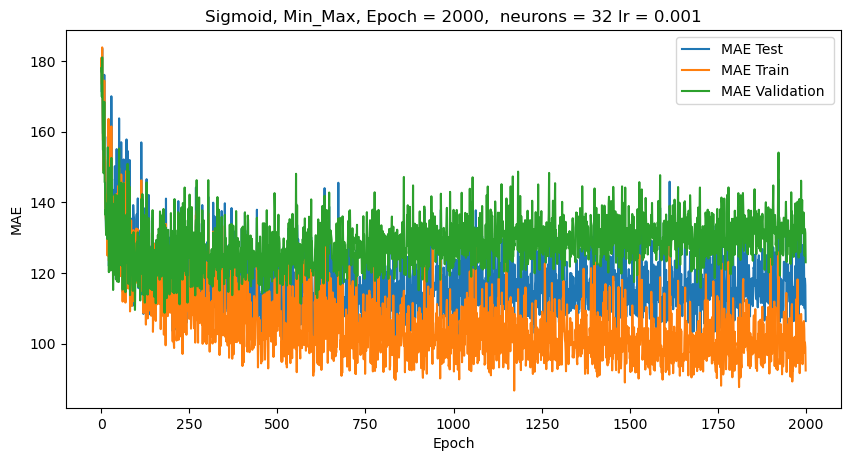

In [695]:
mae = pd.DataFrame()

mae['MAE Test']= v_test['MAE']
mae['MAE Train']= v_train['MAE']
mae['MAE Validation ']= v_validation['MAE']

mae.plot()
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.title('Sigmoid, Min_Max, Epoch = 2000,  neurons = 32 lr = 0.001')

Text(0.5, 1.0, 'Sigmoid, Min_Max, Epoch = 2000,  neurons = 32 lr = 0.001')

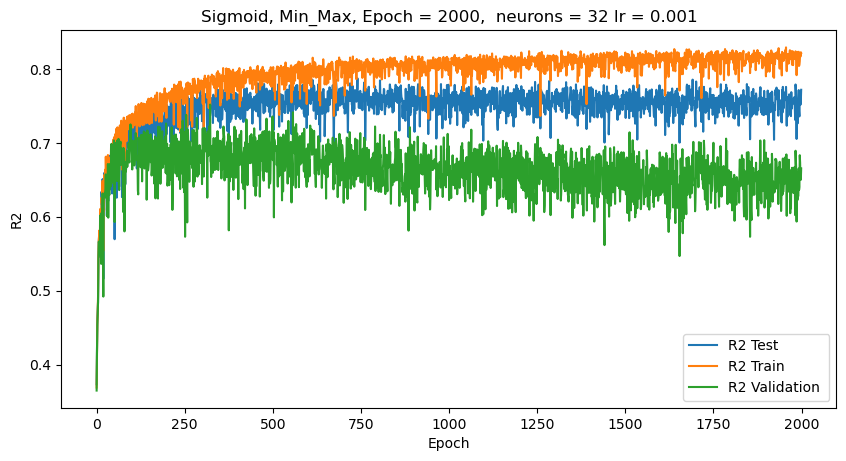

In [696]:
R2 = pd.DataFrame((v_test['R2'], v_train['R2'], v_validation['R2']), columns= [
    'Epoch', 'R2 Test', 'R2 Train', 'R2 Validation' ] ).set_index('Epoch')

r2 = pd.DataFrame()

r2['R2 Test']= v_test['R2']
r2['R2 Train']= v_train['R2']
r2['R2 Validation ']= v_validation['R2']

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

r2.plot()
plt.ylabel("R2")
plt.xlabel("Epoch")
plt.title('Sigmoid, Min_Max, Epoch = 2000,  neurons = 32 lr = 0.001')

In [846]:
x = torch.log10(torch.from_numpy(np.concatenate((X_train, X_test), axis=0))) # add log10 
y = torch.from_numpy(np.concatenate((Y_train, Y_test), axis=0))

print(x)

tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)


In [759]:
volume_train_noise = []
volume_val_noise = []
volume_test_noise = []

R2_Test_noise = []
R2_Train_noise = []
R2_Val_noise = []
MAE_Test_noise = []
MAE_Train_noise = []
MAE_Val_noise = []

In [760]:
for feature_idx in range(0, 550, 1):
    x = torch.log10(torch.from_numpy(np.concatenate((X_train, X_test), axis=0))) 
    X_noisy = x.clone()
    print('feature_idx : ', feature_idx )
    
    # get the current feature and its standard deviation
    feature = x[:, feature_idx]
    std = torch.std(feature)
    
    # add random noise to the current feature
    noise = torch.randn_like(feature) * std
    X_noisy[:, feature_idx] += noise
    x = X_noisy
    print(x)
    
    x_min_train =  train_dataset.x_min 
    x_max_train =  train_dataset.x_max

    y_min_train =  train_dataset.y_min
    y_max_train =  train_dataset.y_max    
    
    x_train_0, x_test, y_train_0, y_test = train_test_split(x, y, test_size = 0.2)
    x_train, x_val, y_train, y_val = train_test_split(x_train_0, y_train_0,  train_size = 0.8)

    train_dataset = dummy_dataset(x_train, y_train)
    test_dataset = dummy_dataset(x_test, y_test)
    val_dataset = dummy_dataset(x_val, y_val)

    trainLoader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    testLoader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    valLoader =  DataLoader(val_dataset, batch_size=8, shuffle=False)
    
    with torch.no_grad():
        
        out_val_noise = model(inputs.float())
        preds_test = []
        labels_test_preds = []
        for i, (inputs_test, labels_test) in enumerate(testLoader): 
            preds_test.append(model(inputs_test.float()).numpy())
            labels_test_preds.append(labels_test.numpy())
        preds_test = np.vstack(preds_test)
        labels_test_preds = np.vstack(labels_test_preds)
            #test metrics per epoch
        preds_reversed_norm_test = (torch.from_numpy(preds_test)* (y_max_train - y_min_train )) + y_min_train
        preds_reversed_norm_test[preds_reversed_norm_test< 0 ] = 0 # negative values become zeros
        label_reversed_norm_test = (torch.from_numpy(labels_test_preds)* (y_max_train - y_min_train )) + y_min_train
        mae_test_noise = mean_absolute_error(preds_reversed_norm_test, label_reversed_norm_test)
        r2_test_noise = r2score(preds_reversed_norm_test, label_reversed_norm_test)
        volume_test_noise.append([epoch, mae_test_noise.item(), r2_test_noise.item()])

        print('R2 test: {}'.format(r2_test_noise.item()))
        print('MAE test: {}'.format(mae_test_noise.item()))


    with torch.no_grad(): 
        preds_train = []
        labels_train_preds = []
        for i, (inputs_train, labels_train) in enumerate(trainLoader): 
            preds_train.append(model(inputs_train.float()).numpy())
            labels_train_preds.append(labels_train.numpy())
        preds_train = np.vstack(preds_train)
        labels_train_preds = np.vstack(labels_train_preds)
                #train metrics per epoch
        preds_reversed_norm_train = (torch.from_numpy(preds_train)* (y_max_train - y_min_train )) + y_min_train
        preds_reversed_norm_train[preds_reversed_norm_train<0] = 0 # negative values become zeros
        label_reversed_norm_train = (torch.from_numpy(labels_train_preds)* (y_max_train - y_min_train )) + y_min_train 
        r2_train_noise = r2score(preds_reversed_norm_train, label_reversed_norm_train) 
        mae_train_noise = mean_absolute_error(preds_reversed_norm_train, label_reversed_norm_train)
        volume_train_noise.append([epoch, mae_train_noise.data.item(), r2_train_noise.data.item()]) 
        #print('R2 train: {}'.format(r2_train_noise.item()))
        #print('MAE train: {}'.format(mae_train_noise.item()))

    with torch.no_grad(): 
        preds_val = []
        labels_val_preds = []
        for i, (inputs_val, labels_val) in enumerate(valLoader): 
            preds_val.append(model(inputs_val.float()).numpy())
            labels_val_preds.append(labels_val.numpy())
        preds_val = np.vstack(preds_val)
        labels_val_preds = np.vstack(labels_val_preds)
            #validation metrics per epoch
        preds_reversed_norm_val =(torch.from_numpy(preds_val)* (y_max_train - y_min_train )) + y_min_train
        preds_reversed_norm_val[preds_reversed_norm_val<0] = 0 # negative values become zeros
        label_reversed_norm_val = (torch.from_numpy(labels_val_preds)* (y_max_train - y_min_train )) + y_min_train
        r2_val_noise = r2score(preds_reversed_norm_val, label_reversed_norm_val) 
        mae_val_noise = mean_absolute_error(preds_reversed_norm_val, label_reversed_norm_val)
        volume_val_noise.append([epoch, mae_val_noise.data.item(), r2_val_noise.data.item()])
        R2_Test_noise.append(r2_test_noise.data.item())
        R2_Train_noise.append(r2_val_noise.data.item())
        R2_Val_noise.append(r2_val_noise.data.item())
        MAE_Test_noise.append(mae_val_noise.data.item())
        MAE_Train_noise.append(mae_val_noise.data.item())
        MAE_Val_noise.append(mae_val_noise.data.item())
        
    

feature_idx :  0
tensor([[5.1568, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.8746, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.1220, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.6755, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.2330, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [5.1573, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7621756196022034
MAE test: 109.0063705444336
feature_idx :  1
tensor([[4.4506, 4.7941, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.6796, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.2565, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.3930, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.5703, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.0515, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7400211095809937
MAE test: 113.42742919921875
f

R2 test: 0.7766895890235901
MAE test: 108.51510620117188
feature_idx :  17
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7847851514816284
MAE test: 103.83367156982422
feature_idx :  18
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7841238975524902
MAE test: 103.43187713623047
feature_idx :  34
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7893404364585876
MAE test: 100.55658721923828
feature_idx :  35
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7923086881637573
MAE test: 96.61099243164062
feature_idx :  51
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7519810199737549
MAE test: 103.9180679321289
feature_idx :  52
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)


R2 test: 0.78863924741745
MAE test: 102.83696746826172
feature_idx :  68
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7853590846061707
MAE test: 105.5910415649414
feature_idx :  69
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R

R2 test: 0.666923463344574
MAE test: 125.69375610351562
feature_idx :  85
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.8013519048690796
MAE test: 98.46717834472656
feature_idx :  86
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)


R2 test: 0.7728478312492371
MAE test: 102.83694458007812
feature_idx :  102
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.720450758934021
MAE test: 115.00752258300781
feature_idx :  103
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.777279257774353
MAE test: 104.05647277832031
feature_idx :  119
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7840993404388428
MAE test: 99.88522338867188
feature_idx :  120
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.762607991695404
MAE test: 108.75838470458984
feature_idx :  136
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7708508968353271
MAE test: 106.13321685791016
feature_idx :  137
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.745634138584137
MAE test: 107.21128845214844
feature_idx :  153
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7836090326309204
MAE test: 103.89972686767578
feature_idx :  154
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.7291840314865112
MAE test: 111.2809829711914
feature_idx :  170
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.778411865234375
MAE test: 104.18647003173828
feature_idx :  171
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7836437225341797
MAE test: 102.79348754882812
feature_idx :  187
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7837494611740112
MAE test: 102.38431549072266
feature_idx :  188
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.8010424375534058
MAE test: 99.93519592285156
feature_idx :  204
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7774057388305664
MAE test: 106.73419952392578
feature_idx :  205
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.756380558013916
MAE test: 106.97142791748047
feature_idx :  221
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.8080422282218933
MAE test: 98.60092163085938
feature_idx :  222
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7964342832565308
MAE test: 97.12442779541016
feature_idx :  238
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.765384316444397
MAE test: 102.78675079345703
feature_idx :  239
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7608460187911987
MAE test: 103.5065689086914
feature_idx :  255
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7834814786911011
MAE test: 100.52613830566406
feature_idx :  256
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.6996185779571533
MAE test: 116.87651824951172
feature_idx :  272
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.6841305494308472
MAE test: 122.47587585449219
feature_idx :  273
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.7677513957023621
MAE test: 105.52740478515625
feature_idx :  289
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7180054783821106
MAE test: 115.23809051513672
feature_idx :  290
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.790634036064148
MAE test: 98.11029815673828
feature_idx :  306
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7848615050315857
MAE test: 99.45698547363281
feature_idx :  307
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)

R2 test: 0.7755395174026489
MAE test: 104.36973571777344
feature_idx :  323
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.8038862943649292
MAE test: 95.00259399414062
feature_idx :  324
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.7761275768280029
MAE test: 105.15299224853516
feature_idx :  340
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7979593873023987
MAE test: 99.03794860839844
feature_idx :  341
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.72420334815979
MAE test: 109.58509063720703
feature_idx :  357
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7875359058380127
MAE test: 98.21572875976562
feature_idx :  358
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)

R2 test: 0.7976616024971008
MAE test: 101.44801330566406
feature_idx :  374
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7945586442947388
MAE test: 98.31785583496094
feature_idx :  375
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.784092366695404
MAE test: 110.05464172363281
feature_idx :  391
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7474352717399597
MAE test: 108.92298889160156
feature_idx :  392
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.7336828708648682
MAE test: 114.20896911621094
feature_idx :  408
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7688606977462769
MAE test: 109.05062866210938
feature_idx :  409
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.7586945295333862
MAE test: 108.97254943847656
feature_idx :  425
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7913833856582642
MAE test: 105.05160522460938
feature_idx :  426
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.7975555658340454
MAE test: 96.64083862304688
feature_idx :  442
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7965520620346069
MAE test: 96.78361511230469
feature_idx :  443
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7779737114906311
MAE test: 107.07896423339844
feature_idx :  459
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7551597356796265
MAE test: 112.58732604980469
feature_idx :  460
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.7856431007385254
MAE test: 104.3185806274414
feature_idx :  476
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.793730616569519
MAE test: 100.5513687133789
feature_idx :  477
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)

R2 test: 0.7823847532272339
MAE test: 101.5552978515625
feature_idx :  493
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7955816388130188
MAE test: 98.38731384277344
feature_idx :  494
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64

R2 test: 0.7275582551956177
MAE test: 113.28270721435547
feature_idx :  510
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7522075176239014
MAE test: 110.40248107910156
feature_idx :  511
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float

R2 test: 0.7936804294586182
MAE test: 101.00917053222656
feature_idx :  527
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.748416543006897
MAE test: 102.58479309082031
feature_idx :  528
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

R2 test: 0.7620509266853333
MAE test: 107.81403350830078
feature_idx :  544
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float64)
R2 test: 0.7288972735404968
MAE test: 115.2606430053711
feature_idx :  545
tensor([[4.4506, 4.4504, 4.4500,  ..., 4.4229, 4.4232, 4.4249],
        [4.4405, 4.4400, 4.4417,  ..., 4.4214, 4.4196, 4.4133],
        [4.4455, 4.4468, 4.4467,  ..., 4.4165, 4.4198, 4.4233],
        ...,
        [4.4910, 4.4911, 4.4915,  ..., 4.4557, 4.4572, 4.4582],
        [4.4928, 4.4931, 4.4937,  ..., 4.4579, 4.4587, 4.4592],
        [4.4931, 4.4932, 4.4931,  ..., 4.4631, 4.4639, 4.4649]],
       dtype=torch.float6

In [767]:
metrics_noise_df = pd.DataFrame()
metrics_noise_df

""


In [768]:
metrics_noise_df = pd.DataFrame({
    'R2 Test': R2_Test_noise,
    'R2 Train': R2_Train_noise,
    'R2 Validation' : R2_Val_noise,
    'MAE Test': MAE_Test_noise,
    'MAE Train': MAE_Train_noise,
    'MAE Validation' : MAE_Val_noise})


print(metrics_noise_df)

      R2 Test  R2 Train  R2 Validation    MAE Test   MAE Train  MAE Validation
0    0.762176  0.757917       0.757917  110.670319  110.670319      110.670319
1    0.740021  0.604016       0.604016  137.246628  137.246628      137.246628
2    0.668951  0.696388       0.696388  116.784286  116.784286      116.784286
3    0.718522  0.760241       0.760241  110.299004  110.299004      110.299004
4    0.766090  0.733020       0.733020  116.648247  116.648247      116.648247
..        ...       ...            ...         ...         ...             ...
545  0.776521  0.723327       0.723327  116.717613  116.717613      116.717613
546  0.729853  0.756515       0.756515  101.687767  101.687767      101.687767
547  0.770788  0.682423       0.682423  121.384300  121.384300      121.384300
548  0.763740  0.760512       0.760512  102.655022  102.655022      102.655022
549  0.794115  0.778820       0.778820  106.934921  106.934921      106.934921

[550 rows x 6 columns]


Text(0.5, 1.0, 'R2 Tr/Tst/Val')

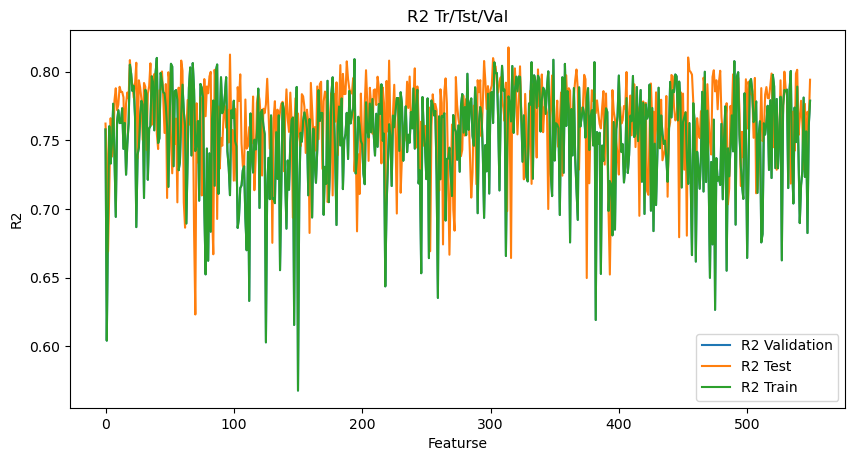

In [769]:
R2_noise = metrics_noise_df[['R2 Validation', 'R2 Test', 'R2 Train']]
R2_noise.plot.line()
plt.ylabel("R2")
plt.xlabel("Featurse")
plt.title('R2 Tr/Tst/Val')


Text(0.5, 1.0, 'MAE Tr/Tst/Val')

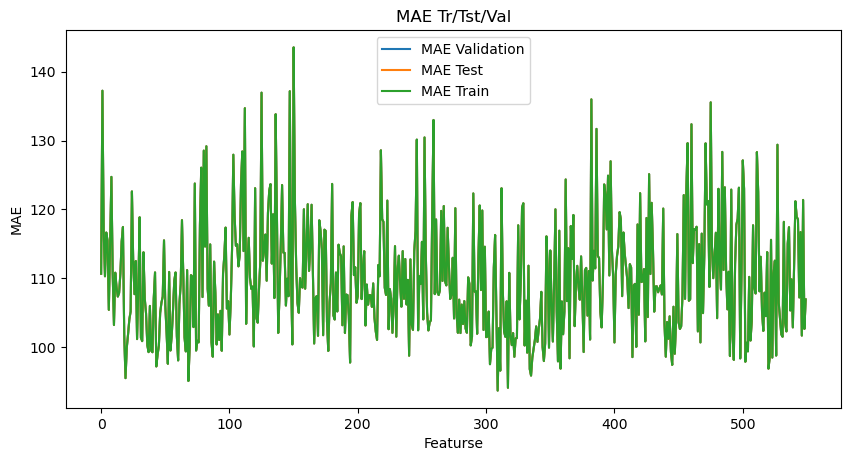

In [770]:
mae_noise =metrics_noise_df[['MAE Validation', 'MAE Test', 'MAE Train']]
mae_noise.plot.line()
plt.ylabel("MAE")
plt.xlabel("Featurse")
plt.title('MAE Tr/Tst/Val')

In [803]:
mae_noise

,MAE Validation,MAE Test,MAE Train
0,110.670319,110.670319,110.670319
1,137.246628,137.246628,137.246628
2,116.784286,116.784286,116.784286
3,110.299004,110.299004,110.299004
4,116.648247,116.648247,116.648247
...,...,...,...
545,116.717613,116.717613,116.717613
546,101.687767,101.687767,101.687767
547,121.384300,121.384300,121.384300
548,102.655022,102.655022,102.655022


In [847]:
volume_train = []
volume_val = []
volume_test = []

R2_Test = []
R2_Train = []
R2_Val = []
MAE_Test = []
MAE_Train = []
MAE_Val = []

In [864]:
model = torch.load('model.pt')
model

OrderedDict([('dense.weight',
              tensor([[ 3.3381,  3.6664,  3.9831,  ..., -1.5343, -1.8062, -2.3366],
                      [ 1.2982,  1.1977,  0.1593,  ..., -0.7537, -0.1936,  1.1696],
                      [ 0.5759,  1.7434,  0.8982,  ..., -1.3429, -3.6280, -5.0316],
                      ...,
                      [ 6.1035,  6.1598,  5.5520,  ...,  1.3837,  1.0378,  1.6317],
                      [ 6.5343,  6.1314,  4.8238,  ..., -2.7735, -2.7774, -3.2905],
                      [ 3.3940,  3.5690,  3.1991,  ...,  2.6991,  2.8075,  3.5502]])),
             ('dense.bias',
              tensor([  0.9706, -13.5586, -15.8945,  12.7962,  -5.8107,   2.3493,  -0.2385,
                       12.0325,  -8.9889,  -8.5144,   1.0344, -15.1585,   0.1118,   0.3639,
                        9.8649,   8.8392,   0.0689,  10.7917,   2.7102, -12.6504,   0.9128,
                        6.3033,   6.4354,  -1.1023, -18.8096, -15.9839,   4.7392,  -3.6084,
                        7.8058,  -8.4655

In [862]:
for i in range(0, 550, 1):
    with torch.no_grad():
        out_ = model(inputs.float())
        preds_test = []
        labels_test_preds = []
        for i, (inputs_test, labels_test) in enumerate(testLoader): 
            preds_test.append(model(inputs_test.float()).numpy())
            labels_test_preds.append(labels_test.numpy())
        preds_test = np.vstack(preds_test)
        labels_test_preds = np.vstack(labels_test_preds)
            #test metrics per epoch
        preds_reversed_norm_test = (torch.from_numpy(preds_test)* (y_max_train - y_min_train )) + y_min_train
        preds_reversed_norm_test[preds_reversed_norm_test< 0 ] = 0 # negative values become zeros
        label_reversed_norm_test = (torch.from_numpy(labels_test_preds)* (y_max_train - y_min_train )) + y_min_train
        print('preds:', preds_reversed_norm_test, 'labels:', label_reversed_norm_test)
        mae_test = mean_absolute_error(preds_reversed_norm_test, label_reversed_norm_test)
        r2_test = r2score(preds_reversed_norm_test, label_reversed_norm_test)
        volume_test.append([epoch, mae_test.item(), r2_test.item()])
        print('R2 test: {}'.format(r2_test.item()))
        print('MAE test: {}'.format(mae_test.item()))


    with torch.no_grad(): 
        preds_train = []
        labels_train_preds = []
        for i, (inputs_train, labels_train) in enumerate(trainLoader): 
            preds_train.append(model(inputs_train.float()).numpy())
            labels_train_preds.append(labels_train.numpy())
        preds_train = np.vstack(preds_train)
        labels_train_preds = np.vstack(labels_train_preds)
                #train metrics per epoch
        preds_reversed_norm_train = (torch.from_numpy(preds_train)* (y_max_train - y_min_train )) + y_min_train
        preds_reversed_norm_train[preds_reversed_norm_train<0] = 0 # negative values become zeros
        label_reversed_norm_train = (torch.from_numpy(labels_train_preds)* (y_max_train - y_min_train )) + y_min_train 
        r2_train = r2score(preds_reversed_norm_train, label_reversed_norm_train) 
        mae_train = mean_absolute_error(preds_reversed_norm_train, label_reversed_norm_train)
        volume_train.append([epoch, mae_train.data.item(), r2_train.data.item()]) 
        #print('R2 train: {}'.format(r2_train_noise.item()))
        #print('MAE train: {}'.format(mae_train_noise.item()))

    with torch.no_grad(): 
        preds_val = []
        labels_val_preds = []
        for i, (inputs_val, labels_val) in enumerate(valLoader): 
            preds_val.append(model(inputs_val.float()).numpy())
            labels_val_preds.append(labels_val.numpy())
        preds_val = np.vstack(preds_val)
        labels_val_preds = np.vstack(labels_val_preds)
            #validation metrics per epoch
        preds_reversed_norm_val =(torch.from_numpy(preds_val)* (y_max_train - y_min_train )) + y_min_train
        preds_reversed_norm_val[preds_reversed_norm_val<0] = 0 # negative values become zeros
        label_reversed_norm_val = (torch.from_numpy(labels_val_preds)* (y_max_train - y_min_train )) + y_min_train
        r2_val = r2score(preds_reversed_norm_val, label_reversed_norm_val) 
        mae_val = mean_absolute_error(preds_reversed_norm_val, label_reversed_norm_val)
        volume_val.append([epoch, mae_val.data.item(), r2_val.data.item()])
        R2_Test.append(r2_test.data.item())
        R2_Train.append(r2_val.data.item())
        R2_Val.append(r2_val.data.item())
        MAE_Test.append(mae_val.data.item())
        MAE_Train.append(mae_val.data.item())
        MAE_Val.append(mae_val.data.item())

TypeError: 'collections.OrderedDict' object is not callable

In [851]:
metrics_original = pd.DataFrame()
metrics_original

""


In [852]:
metrics_original = pd.DataFrame({
    'R2 Test': R2_Test,
    'R2 Train': R2_Train,
    'R2 Validation' : R2_Val,
    'MAE Test': MAE_Test,
    'MAE Train': MAE_Train,
    'MAE Validation' : MAE_Val})
metrics_original

,R2 Test,R2 Train,R2 Validation,MAE Test,MAE Train,MAE Validation
0,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
1,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
2,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
3,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
4,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
...,...,...,...,...,...,...
545,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
546,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
547,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888
548,-0.160998,-0.157871,-0.157871,264.328888,264.328888,264.328888


In [807]:
new_row = pd.DataFrame({
'R2 Train': [0.750637],
'MAE Train': [107.839134],
'R2 Validation' : [0.750637],
'MAE Validation' : [107.839134],
'R2 Test': [0.789793],
'MAE Test': [107.839134]})

metrics = new_row.append(metrics_noise_df, ignore_index=True, sort=False)
metrics

/var/folders/vh/9wzrw_412p95jkwkptx2qz_h0000gn/T/ipykernel_2037/3126905638.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = new_row.append(metrics_noise_df, ignore_index=True, sort=False)


,R2 Train,MAE Train,R2 Validation,MAE Validation,R2 Test,MAE Test
0,0.750637,107.839134,0.750637,107.839134,0.789793,107.839134
1,0.757917,110.670319,0.757917,110.670319,0.762176,110.670319
2,0.604016,137.246628,0.604016,137.246628,0.740021,137.246628
3,0.696388,116.784286,0.696388,116.784286,0.668951,116.784286
4,0.760241,110.299004,0.760241,110.299004,0.718522,110.299004
...,...,...,...,...,...,...
546,0.723327,116.717613,0.723327,116.717613,0.776521,116.717613
547,0.756515,101.687767,0.756515,101.687767,0.729853,101.687767
548,0.682423,121.384300,0.682423,121.384300,0.770788,121.384300
549,0.760512,102.655022,0.760512,102.655022,0.763740,102.655022


In [815]:
r2 = metrics_original[['R2 Validation', 'R2 Test', 'R2 Train']]
mae = metrics_original[['MAE Validation', 'MAE Test', 'MAE Train']]
print(mae)

   MAE Validation    MAE Test   MAE Train
0      107.839134  107.839134  107.839134


In [816]:
mae_noise

,MAE Validation,MAE Test,MAE Train
0,110.670319,110.670319,110.670319
1,137.246628,137.246628,137.246628
2,116.784286,116.784286,116.784286
3,110.299004,110.299004,110.299004
4,116.648247,116.648247,116.648247
...,...,...,...
545,116.717613,116.717613,116.717613
546,101.687767,101.687767,101.687767
547,121.384300,121.384300,121.384300
548,102.655022,102.655022,102.655022


In [814]:
# mae_noise - mae
new_df_mae = mae_noise.sub(mae.iloc[0])
new_df_mae

,MAE Validation,MAE Test,MAE Train
0,2.831184,2.831184,2.831184
1,29.407494,29.407494,29.407494
2,8.945152,8.945152,8.945152
3,2.459869,2.459869,2.459869
4,8.809113,8.809113,8.809113
...,...,...,...
545,8.878479,8.878479,8.878479
546,-6.151367,-6.151367,-6.151367
547,13.545166,13.545166,13.545166
548,-5.184113,-5.184113,-5.184113


In [818]:
# sorted df
sorted_df_mae = new_df_mae.sort_values(by=['MAE Test']) 
sorted_df_mae

,MAE Validation,MAE Test,MAE Train
309,-14.137070,-14.137070,-14.137070
317,-13.729568,-13.729568,-13.729568
68,-12.745560,-12.745560,-12.745560
19,-12.332901,-12.332901,-12.332901
335,-11.959602,-11.959602,-11.959602
...,...,...,...
382,28.147102,28.147102,28.147102
125,29.126289,29.126289,29.126289
147,29.336052,29.336052,29.336052
1,29.407494,29.407494,29.407494


In [823]:
middle = len(sorted_df_mae) // 2 # фильтруем признаки, выбирая q = 0,5

# разделяем DataFrame на два DataFrame с сохранением индексов
df1_mae = sorted_df_mae.iloc[:middle, :]
df2_mae = sorted_df_mae.iloc[middle:, :]
df2_mae

,MAE Validation,MAE Test,MAE Train
156,0.961052,0.961052,0.961052
118,0.971634,0.971634,0.971634
432,0.974457,0.974457,0.974457
433,1.005875,1.005875,1.005875
415,1.138435,1.138435,1.138435
...,...,...,...
382,28.147102,28.147102,28.147102
125,29.126289,29.126289,29.126289
147,29.336052,29.336052,29.336052
1,29.407494,29.407494,29.407494


In [824]:
# x transposed to torch.Size([550, 35400])
x_transposed = x.t()
# get df2_mae index to x 
data_mae = x_transposed[df2_mae.index]
data_mae

tensor([[6.2373, 6.1779, 6.2488,  ..., 4.7916, 4.7982, 4.7986],
        [5.2252, 5.1607, 5.1976,  ..., 4.5575, 4.5640, 4.5644],
        [4.4982, 4.4782, 4.4902,  ..., 4.3797, 4.3796, 4.3856],
        ...,
        [5.9886, 5.9218, 5.9844,  ..., 4.7185, 4.7235, 4.7233],
        [4.4504, 4.4400, 4.4468,  ..., 4.4911, 4.4931, 4.4932],
        [6.0885, 6.0019, 6.0589,  ..., 4.7410, 4.7468, 4.7489]],
       dtype=torch.float64)

In [825]:
# load model
model = torch.load('checkpoint.pt')
# layers
dense_weight = model['dense.weight']
out_weight = model['out.weight']
print(dense_weight.shape, out_weight.shape)

torch.Size([32, 550]) torch.Size([2, 32])


In [826]:
avereges = []

A_matrix = np.matrix(dense_weight).transpose()
B_matrix = np.matrix(out_weight).transpose()
# dense_weight * out_weight
C_matrix = A_matrix.dot(B_matrix)
#C_matrix_m = abs(C_matrix)
avereges.append(np.mean(C_matrix_m, axis=1))

In [827]:
col1 = avereges[0] 

In [828]:
# Суммирование значений в столбце 
sum_col1 = col1.sum()
print(sum_col1)

23.240751


In [829]:
sum_col1_norm = col1 / sum_col1 #norm
sum_col1_norm

matrix([[1.9731470e-03],
        [3.2284597e-03],
        [3.1139473e-03],
        [2.8126519e-03],
        [1.6395859e-03],
        [1.9768416e-03],
        [2.6781985e-03],
        [3.2477044e-03],
        [2.9307476e-03],
        [2.5814935e-03],
        [2.0090353e-03],
        [2.2430343e-03],
        [2.7900767e-03],
        [2.3507059e-03],
        [2.4306320e-03],
        [2.3709375e-03],
        [2.1788906e-03],
        [2.3319232e-03],
        [2.5619152e-03],
        [1.8100747e-03],
        [1.7125824e-03],
        [1.9353641e-03],
        [2.2719873e-03],
        [2.8684684e-03],
        [1.9781040e-03],
        [2.2931471e-03],
        [2.4867868e-03],
        [2.0475201e-03],
        [1.7892442e-03],
        [1.3531467e-03],
        [3.4478460e-03],
        [2.7260557e-03],
        [1.9499703e-03],
        [3.1587437e-03],
        [2.2481272e-03],
        [2.5235529e-03],
        [2.6977139e-03],
        [2.3706891e-03],
        [1.9489425e-03],
        [2.5071739e-03],


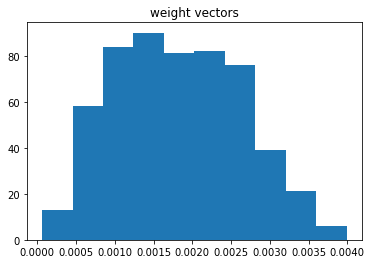

In [830]:
df_sum_col1_norm  = pd.DataFrame(sum_col1_norm)
%matplotlib inline
plt.hist(df_sum_col1_norm)
plt.title('weight vectors')
plt.show()

In [835]:
sorted_df_sum_col1_norm = df_sum_col1_norm.sort_values(by=[0]) # sorted 
sorted_df_sum_col1_norm

,0
536,0.000063
523,0.000165
445,0.000180
459,0.000237
97,0.000309
...,...
62,0.003695
325,0.003737
162,0.003777
345,0.003923


In [836]:
middle = len(df_weight_vector) // 2 # фильтруем признаки, выбирая q = 0,5

# разделяем DataFrame на два DataFrame с сохранением индексов
df1 = df_weight_vector.iloc[:middle, :]
df2 = df_weight_vector.iloc[middle:, :]

In [845]:
mae

,MAE Validation,MAE Test,MAE Train
0,107.839134,107.839134,107.839134


In [837]:
# get df2 index to x 
data = x_transposed[df2.index]
data

tensor([[4.4967, 4.4976, 4.4986,  ..., 4.4834, 4.4848, 4.4853],
        [4.4061, 4.4180, 4.4087,  ..., 4.4086, 4.4082, 4.4102],
        [5.8070, 5.7672, 5.8390,  ..., 4.6803, 4.6843, 4.6892],
        ...,
        [6.3574, 6.3208, 6.3795,  ..., 4.8396, 4.8455, 4.8450],
        [5.0462, 5.0879, 5.0972,  ..., 4.5320, 4.5383, 4.5428],
        [5.0872, 5.1214, 5.1517,  ..., 4.5406, 4.5474, 4.5504]],
       dtype=torch.float64)

In [842]:
# Построение scatter plot
plt.scatter(new_df_mae['MAE Validation'], new_df_mae['MAE Validation'], c='blue', label='Validation')
plt.scatter(new_df_mae['MAE Train'], mae['MAE Train'], c='red', label='Train')
plt.scatter(new_df_mae['MAE Test'], mae['MAE Train'], c='green', label='Test')

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
plt.title("MAE Scatter Plot")
plt.xlabel("MAE")
plt.ylabel("MAE")
plt.legend()
plt.show()


TypeError: scatter() missing 1 required positional argument: 'y'

In [844]:
new_df_mae

,MAE Validation,MAE Test,MAE Train
0,2.831184,2.831184,2.831184
1,29.407494,29.407494,29.407494
2,8.945152,8.945152,8.945152
3,2.459869,2.459869,2.459869
4,8.809113,8.809113,8.809113
...,...,...,...
545,8.878479,8.878479,8.878479
546,-6.151367,-6.151367,-6.151367
547,13.545166,13.545166,13.545166
548,-5.184113,-5.184113,-5.184113


In [159]:
model2000 = torch.load('checkpoint.pt')
dense_weight = model2000['dense.weight']
out_weight = model2000['out.weight']
print(dense_weight.shape, out_weight.shape)

torch.Size([32, 550]) torch.Size([2, 32])


In [131]:
y.shape

torch.Size([35400, 2])

In [132]:
dense_weight

tensor([[ 0.0333, -0.0064, -0.0095,  ...,  0.0225,  0.0458,  0.0276],
        [ 0.0291, -0.0157, -0.0262,  ...,  0.0136,  0.0158,  0.0412],
        [-0.0433,  0.0069, -0.0035,  ..., -0.0426, -0.0170, -0.0387],
        ...,
        [ 0.0444, -0.0099,  0.0057,  ...,  0.0002, -0.0084, -0.0097],
        [-0.0343, -0.0191, -0.0211,  ...,  0.0143, -0.0570, -0.0443],
        [-0.0465, -0.0974, -0.0616,  ...,  0.0014, -0.0320, -0.0188]])

In [133]:
out_weight

tensor([[ 0.0836,  0.1527,  0.0437,  0.1584, -0.1141, -0.1136, -0.0796,  0.1467,
          0.1194, -0.0446, -0.1115,  0.0399, -0.0234, -0.1429,  0.0532, -0.1442,
          0.0651,  0.0713,  0.1569, -0.0081,  0.0876,  0.0370, -0.0745, -0.1183,
         -0.0480, -0.1235,  0.1088, -0.0018,  0.0917, -0.0508,  0.1835,  0.1286],
        [ 0.1674,  0.1252,  0.0245,  0.0384,  0.1609, -0.1077,  0.1409,  0.0594,
          0.0158,  0.2323,  0.2526,  0.0232,  0.2333,  0.0600, -0.0569,  0.0282,
          0.1090,  0.1392, -0.0275,  0.0731,  0.0064,  0.1390,  0.0177,  0.1508,
          0.1972,  0.0650, -0.1237, -0.0253,  0.0295,  0.0044,  0.0264, -0.0877]])

In [134]:
avereges = []

A_matrix = np.matrix(dense_weight).transpose()
B_matrix = np.matrix(out_weight).transpose()
C_matrix = A_matrix.dot(B_matrix)
#C_matrix_m = abs(C_matrix)
avereges.append(np.mean(C_matrix_m, axis=1))

In [135]:
C_matrix_m

matrix([[0.06202571, 0.02968914],
        [0.09817934, 0.05188432],
        [0.08462533, 0.06011562],
        ...,
        [0.00447822, 0.02112664],
        [0.0081051 , 0.02639994],
        [0.00076899, 0.02519814]], dtype=float32)

In [136]:
A_matrix[0]

matrix([[ 0.03325771,  0.02907211, -0.04333206,  0.016503  ,  0.02442196,
          0.01466155,  0.01059967,  0.08242293, -0.00041083, -0.01472466,
         -0.01365029,  0.01197493, -0.05013056,  0.11382829, -0.09000064,
          0.04103362, -0.07026989,  0.00963371, -0.08572207, -0.0244784 ,
         -0.08070596,  0.02437949,  0.05343279,  0.00032511,  0.04509815,
          0.02459607, -0.03700313, -0.065133  , -0.02840181,  0.04441327,
         -0.03429278, -0.04647545]], dtype=float32)

In [137]:
col1 = avereges[0] 

In [138]:
# Суммирование значений в столбце 
sum_col1 = col1.sum()

print(sum_col1)

23.240751


In [139]:
sum_col1_norm = col1 / sum_col1
sum_col1_norm

matrix([[1.9731470e-03],
        [3.2284597e-03],
        [3.1139473e-03],
        [2.8126519e-03],
        [1.6395859e-03],
        [1.9768416e-03],
        [2.6781985e-03],
        [3.2477044e-03],
        [2.9307476e-03],
        [2.5814935e-03],
        [2.0090353e-03],
        [2.2430343e-03],
        [2.7900767e-03],
        [2.3507059e-03],
        [2.4306320e-03],
        [2.3709375e-03],
        [2.1788906e-03],
        [2.3319232e-03],
        [2.5619152e-03],
        [1.8100747e-03],
        [1.7125824e-03],
        [1.9353641e-03],
        [2.2719873e-03],
        [2.8684684e-03],
        [1.9781040e-03],
        [2.2931471e-03],
        [2.4867868e-03],
        [2.0475201e-03],
        [1.7892442e-03],
        [1.3531467e-03],
        [3.4478460e-03],
        [2.7260557e-03],
        [1.9499703e-03],
        [3.1587437e-03],
        [2.2481272e-03],
        [2.5235529e-03],
        [2.6977139e-03],
        [2.3706891e-03],
        [1.9489425e-03],
        [2.5071739e-03],


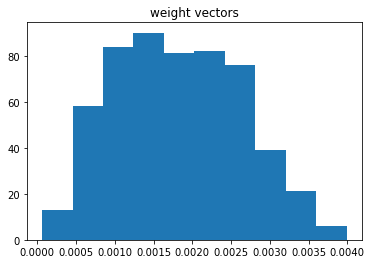

In [129]:
df_sum_col1_norm  = pd.DataFrame(sum_col1_norm)
%matplotlib inline
plt.hist(df_sum_col1_norm)
plt.title('weight vectors')
plt.show()

In [71]:
df_weight_vector # sorted

,0
536,0.001466
523,0.003841
445,0.004181
459,0.005506
97,0.007173
...,...
62,0.085876
325,0.086844
162,0.087778
345,0.091163


In [86]:
middle = len(df_weight_vector) // 2 # фильтруем признаки, выбирая q = 0,5

# разделяем DataFrame на два DataFrame с сохранением индексов
df1 = df_weight_vector.iloc[:middle, :]
df2 = df_weight_vector.iloc[middle:, :]

In [87]:
df2 

,0
28,0.041583
484,0.041659
295,0.041751
141,0.041931
19,0.042067
...,...
62,0.085876
325,0.086844
162,0.087778
345,0.091163


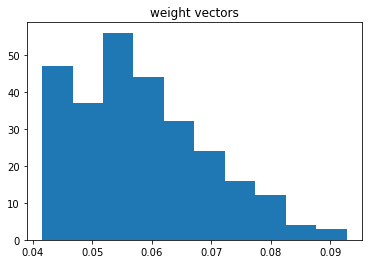

In [115]:
%matplotlib inline
plt.hist(df2)
plt.title('weight vectors')
plt.show()

In [108]:
x_transposed = x.t()
x_transposed.shape

torch.Size([550, 35400])

In [112]:
data = x_transposed[df2.index]
data

tensor([[4.4967, 4.4976, 4.4986,  ..., 4.4834, 4.4848, 4.4853],
        [4.4061, 4.4180, 4.4087,  ..., 4.4086, 4.4082, 4.4102],
        [5.8070, 5.7672, 5.8390,  ..., 4.6803, 4.6843, 4.6892],
        ...,
        [6.3574, 6.3208, 6.3795,  ..., 4.8396, 4.8455, 4.8450],
        [5.0462, 5.0879, 5.0972,  ..., 4.5320, 4.5383, 4.5428],
        [5.0872, 5.1214, 5.1517,  ..., 4.5406, 4.5474, 4.5504]],
       dtype=torch.float64)

In [110]:
data.shape

torch.Size([275, 35400])

In [111]:
data

tensor([[4.4967, 4.4976, 4.4986,  ..., 4.4834, 4.4848, 4.4853],
        [4.4061, 4.4180, 4.4087,  ..., 4.4086, 4.4082, 4.4102],
        [5.8070, 5.7672, 5.8390,  ..., 4.6803, 4.6843, 4.6892],
        ...,
        [6.3574, 6.3208, 6.3795,  ..., 4.8396, 4.8455, 4.8450],
        [5.0462, 5.0879, 5.0972,  ..., 4.5320, 4.5383, 4.5428],
        [5.0872, 5.1214, 5.1517,  ..., 4.5406, 4.5474, 4.5504]],
       dtype=torch.float64)